In [4]:
alg_metrics = {
    "DECoN": [1048, 1450],
    "GRAPES": [660, 780],
    "GATK-gCNV": [770, 471]
}

alg_metrics2 = {
    "DECoN": [1078, 1315],
    "GRAPES": [961, 479],
    "GATK-gCNV": [946, 294],

}

In [25]:
import matplotlib.pyplot as plt
import numpy as np

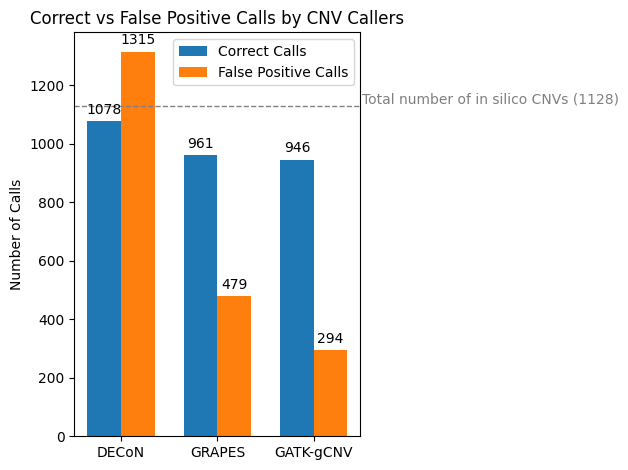

In [6]:
import matplotlib.pyplot as plt
import numpy as np



# Extracting data
labels = list(alg_metrics2.keys())
correct_calls = [metrics[0] for metrics in alg_metrics2.values()]
false_positive_calls = [metrics[1] for metrics in alg_metrics2.values()]

# Setting the position of bars on the X axis
x = np.arange(len(labels))

# Width of a bar
width = 0.35

# Plotting
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, correct_calls, width, label='Correct Calls')
rects2 = ax.bar(x + width/2, false_positive_calls, width, label='False Positive Calls')

# Adding labels, title and custom x-axis tick labels
ax.set_ylabel('Number of Calls')
ax.set_title('Correct vs False Positive Calls by CNV Callers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding a horizontal line at y=1161
total_cnv_line = 1128
ax.axhline(y=total_cnv_line, color='gray', linestyle='--', linewidth=1)
ax.text(len(labels) - 0.5, total_cnv_line + 10, 'Total number of in silico CNVs (1128)', color='gray')

# Adding the values on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Showing plot
fig.tight_layout()
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/algorithms_metrics.png")
plt.show()


In [9]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, make_scorer
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV

class Results_Df():
    algorithms = ["decon", "cnvkit", "grapes", "gatk"]
    def __init__(self, csv_file_path, main_dir):
        self.df = pd.read_csv(csv_file_path)
        print(
            f"Parsing {csv_file_path} where info about CNV detected is stored")
        self.main_dir = main_dir
        self.plot_results_dir = os.path.join(main_dir, "Results", "Model_Plots")
        if not os.path.exists(self.plot_results_dir):
            os.mkdir(self.plot_results_dir)
        self.algs = set()
        self.predicted_col = "true_positive"
        self.check_df()
    def check_df(self):
        for alg in Results_Df.algorithms:
            if alg.lower() in self.df.columns:
                self.algs.add(alg)
    
    def convert_all_columns_to_numeric(self):
        self.df = self.df.apply(pd.to_numeric, errors="coerce")
    
    def are_all_columns_numeric(self):
        return all(pd.api.types.is_numeric_dtype(self.df[col]) for col in self.df.columns)

    def encode_variables(self, Bed_obj):
        print("encoding chr")
        self.encode_chr()
        print("encoding genes")
        self.encode_gene_names(Bed_obj)
        print("encoding type")
        self.encode_type()
        print("encoding true positives")
        self.encode_true_positive()
        print("droping non encoded columns")
        self.drop_non_encoded_columns()
    
    def drop_non_encoded_columns(self):

        columns_to_drop = ["sample", "type", "gene", "qual", "true_positive", "is_outlier"]
        self.df = self.df.drop(columns=columns_to_drop)



    def train_model(self):
        
        self.convert_all_columns_to_numeric()
        self.df.drop(columns=["start", "end", "cnvkit", "cnvkit_qual", "cnv_origin", "is_autosomal"])
        output_csv = os.path.join(self.main_dir, "model_train.csv")
        print(f"Creating model, excel stored in: {output_csv}")
        self.df.to_csv(output_csv)
        X = self.df.drop(columns=[self.predicted_col])
        y = self.df[self.predicted_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        xgb_param_grid = {
            "max_depth": [3, 4, 5],
            "learning_rate": [0.01, 0.05, 0.1],
            "n_estimators": [100, 200, 300],
            "colsample_bytree": [0.3, 0.5, 0.7]
        }
        rf_param_grid = {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
        
        xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
        scorer = make_scorer(f1_score, average="binary")
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=scorer, cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
        print(f"Best parameters found by GridSearchCV: {grid_search.best_params_}")
        print(f"Best F1 score found by GridSearchCV: {grid_search.best_score_}")

         # Evaluate XGBoost
        best_xgb_model = xgb_grid_search.best_estimator_
        xgb_y_pred = best_xgb_model.predict(X_test)
        self.evaluate_model(best_xgb_model, X_test, y_test, xgb_y_pred, 'XGBoost')

        # Initialize and fit Random Forest model
        rf_model = RandomForestClassifier(random_state=42)
        rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring=scorer, cv=5, verbose=1)
        rf_grid_search.fit(X_train, y_train)
        print(f"Random Forest Best parameters: {rf_grid_search.best_params_}")
        print(f"Random Forest Best F1 score: {rf_grid_search.best_score_}")
        
        # Evaluate the best model on the test set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        test_f1_score = f1_score(y_test, y_pred)
        print(f"F1 score on the test set: {test_f1_score}")


        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy on the test set: {accuracy}")

        # Calculate specificity (true negative rate)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        print(f"Specificity (True Negative Rate) on the test set: {specificity}")
    
        # Print the confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(
            f"Confusion Matrix:\n{conf_matrix}")

        # Get feature importances
        feature_importances = best_model.feature_importances_
        features = X.columns
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        print(
            f"Feature Importances:\n{importance_df}"
        )

        # Save the model
        model_dir = os.path.join(self.main_dir, "Models")
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        
        model_path = os.path.join(model_dir, "xbg_model.joblib")
        joblib.dump(best_model, model_path)
        print(f"Model saved to: {model_path}")


        # Identify misclassified instances
        misclassified_mask = (y_test != y_pred)
        misclassified_df = X_test[misclassified_mask]
        misclassified_df['Actual'] = y_test[misclassified_mask]
        misclassified_df['Predicted'] = y_pred[misclassified_mask]

        # Save misclassified instances
        misclassified_output_csv = os.path.join(self.main_dir, "misclassified_instances.csv")
        misclassified_df.to_csv(misclassified_output_csv, index=False)
        print(f"Misclassified instances saved to: {misclassified_output_csv}")

    def encode_true_positive(self):
        self.df["true_positive_encoded"] = self.df["true_positive"].astype(int)
        self.predicted_col = "true_positive_encoded"
    def encode_type(self):
        mapping = {"DEL": 0, "DUP": 1}
        self.df["encoded_type"] = self.df["type"].map(mapping)
    def encode_chr(self):
        self.df['chr'] = self.df['chr'].str.replace('chr', '', regex=False)
        self.df["is_autosomal"] = self.df["chr"].apply(lambda x: 0 if x=="X" or x=="Y" else 1)
        self.df["chr"] = self.df["chr"].replace({"X": 23, "Y":24}).astype(int)

    def get_gene_name_encoded(self, gene_name, Bed_obj):
        """
        Bed obj is not necessary if encode_genes() have been executed
        """
        print(gene_name)
        if not hasattr(Bed_obj, "gene_names"):
            print("obtaining gene names")
            Bed_obj.get_gene_names()
            print(Bed_obj.gene_names)
        
        print(Bed_obj.gene_names)
        try:
            gene_pos = Bed_obj.gene_names.index(gene_name)
            print(gene_pos)
        except ValueError:
            print(
                f"gene name: {gene_name} not found in bed, "
            )
            gene_pos = -1
        return(gene_pos)
    
    def encode_gene_names(self, Bed_obj):
        self.df["genes_encoded"] = self.df["gene"].apply(lambda x: self.get_gene_name_encoded(x, Bed_obj))









    def get_algorithms_bar_plot(self):
        for alg in self.algs:
            plot_path = os.path.join(self.plot_results_dir, f"{alg}_bar_chart.png")
            sns.countplot(x=alg.lower(), hue=self.predicted_col, data=self.df)
            plt.title(f"{alg} vs TP(1)/FP(0)")
            plt.savefig(plot_path)

            plot_path = os.path.join(self.plot_results_dir, f"{alg}_stacked_bar_chart.png")
            cross_tab = pd.crosstab(self.df[alg], self.df[self.predicted_col])
            cross_tab.plot(kind="bar", stacked=True)
            plt.title(f"{alg} vs TP(1)/FN(0)")
            plt.savefig(plot_path)

    def get_heatmap(self):
        plot_path = os.path.join(self.plot_results_dir, f"heatmap.png")
        corr = self.df.corr()
        sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
        plt.title(f"Correlation Heatmap")
        plt.savefig(plot_path)

    def run_model(self, model_class, param_grid, X_train, y_train, X_test, y_test, runs=10):
        best_params_list = []
        f1_scores = []
        accuracies = []
        specificities = []

        for _ in range(runs):
            model = model_class()
            scorer = make_scorer(f1_score, average="binary")
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, verbose=1)
            grid_search.fit(X_train, y_train)

            best_params_list.append(grid_search.best_params_)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            f1_scores.append(f1_score(y_test, y_pred))
            accuracies.append(accuracy_score(y_test, y_pred))

            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            specificities.append(tn / (tn + fp))

        mean_best_params = pd.DataFrame(best_params_list).mean().to_dict()
        mean_f1_score = np.mean(f1_scores)
        mean_accuracy = np.mean(accuracies)
        mean_specificity = np.mean(specificities)

        return mean_best_params, mean_f1_score, mean_accuracy, mean_specificity


    def train_model2(self):
        self.convert_all_columns_to_numeric()
        output_csv = os.path.join(self.main_dir, "model_train.csv")
        print(f"Creating model, excel stored in: {output_csv}")
        self.df.to_csv(output_csv)
        X = self.df.drop(columns=[self.predicted_col])
        y = self.df[self.predicted_col]

        algorithms = {
            "XGBoost": {
                "model_class": XGBClassifier,
                "param_grid": {
                    "max_depth": [3, 4, 5],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "n_estimators": [100, 200, 300],
                    "colsample_bytree": [0.3, 0.5, 0.7]
                }
            },
            "RandomForest": {
                "model_class": RandomForestClassifier,
                "param_grid": {
                    "n_estimators": [100, 200, 300],
                    "max_depth": [None, 10, 20],
                    "min_samples_split": [2, 5, 10]
                }
            }
        }

        results = []
        for name, algorithm in algorithms.items():
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print("Obtained train and test data")
            print(f"Running {name}...")
            mean_best_params, mean_f1_score, mean_accuracy, mean_specificity = self.run_model(
                algorithm["model_class"], algorithm["param_grid"], X_train, y_train, X_test, y_test
            )
            results.append({
                "Algorithm": name,
                "Mean Best Params": mean_best_params,
                "Mean F1 Score": mean_f1_score,
                "Mean Accuracy": mean_accuracy,
                "Mean Specificity": mean_specificity
            })

        results_df = pd.DataFrame(results)
        print(f"Results:\n{results_df}")

        # Save the results
        results_csv = os.path.join(self.main_dir, "model_comparison_results.csv")
        results_df.to_csv(results_csv, index=False)
        print(f"Model comparison results saved to: {results_csv}")

    def get_alg_calls(self, alg):
        allowed_algs = ["decon", "grapes", "gatk"]
        if alg not in allowed_algs:
            raise ValueError(
                f"{alg} is not an allowed algorithm to be selected, allowed algs: {allowed_algs}")

        return (self.df[self.df[alg] == 1])

    def numb_exons_vs_alg_calls(self, alg):
        algorithms = ["gatk", "decon", "grapes"]
        precisions = {alg: [] for alg in algorithms}
        recalls = {alg: [] for alg in algorithms}
        exons_range = range(0, 9)
    
        for exon in exons_range:
            filtered_df = self.df[(self.df["numb_exons"] >= exon) & (self.df["chr"] != "chrX")]
    
            for alg in algorithms:
                true_positives = len(filtered_df[filtered_df["true_positive"] == True])
                alg_calls = filtered_df[filtered_df[alg] == 1]
                positive_alg_calls = len(alg_calls[alg_calls["true_positive"] == True])
                negative_alg_calls = len(alg_calls[alg_calls["true_positive"] == False])
    
                precision = positive_alg_calls / len(alg_calls) if len(alg_calls) > 0 else 0
                recall = positive_alg_calls / true_positives if true_positives > 0 else 0
    
                precisions[alg].append(precision)
                recalls[alg].append(recall)
    
        # Plot precision
        plt.figure(figsize=(14, 10))
        for alg in algorithms:
            plt.plot(exons_range, precisions[alg], marker='o', label=f'Precision {alg}')
        precision_path  = os.path.join(self.main_dir, "precision_plot.png")
        plt.xticks(ticks=exons_range)
        plt.xlabel('Minimum Number of Exons')
        plt.ylabel('Precision')
        plt.title('Precision vs Number of Exons for All Algorithms')
        plt.legend()
        plt.grid(True)
        plt.savefig(precision_path)
        plt.show()
        
    
        # Plot recall
        recall_path  = os.path.join(self.main_dir, "recall_plot.png")

        plt.figure(figsize=(14, 10))
        for alg in algorithms:
            plt.plot(exons_range, recalls[alg], marker='o', label=f'Recall {alg}')
        plt.xticks(ticks=exons_range)
        plt.xlabel('Minimum Number of Exons')
        plt.ylabel('Recall')
        plt.title('Recall vs Number of Exons for All Algorithms')
        plt.legend()
        plt.grid(True)
        plt.savefig(recall_path)
        plt.show()

In [10]:
class Bed():
    def __init__(
            self,
            bed_path,
            interval_list_path="",
            annotated_intervals_path="",
            preprocessed_intervals_path="",
            filtered_intervals_path="",
            grapes_bed_path="",
            sorted_merged_bed="suddxl.v3.147.ROI.sorted.merged.bed",
            roi_bed = "suddxl.v3.147.ROI.bed"
        ):
        self.path = bed_path
        self.filename = os.path.basename(self.path)
        self.dir = os.path.dirname(self.path)


        self.sorted_merged_bed_filename = sorted_merged_bed
        self.roi_bed = os.path.join(self.dir, roi_bed)
        self.roi_bed_filename = roi_bed


        self.interval_list_path = interval_list_path
        self.interval_list_filename = os.path.basename(self.interval_list_path)

        self.preprocessed_intervals_path = preprocessed_intervals_path
        self.preprocessed_intervals_filename = os.path.basename(self.preprocessed_intervals_path)

        self.annotated_intervals_path = annotated_intervals_path
        self.annotated_intevals_filename = os.path.basename(annotated_intervals_path)
        
        self.filtered_intervals_path = filtered_intervals_path
        self.filtered_intervals_filename = os.path.basename(self.filtered_intervals_path)
        
        self.grapes_bed_path = grapes_bed_path
        self.grapes_bed_filename = os.path.basename(self.grapes_bed_path)
        
        self.volume = "/bed_dir"

    def get_gene_names(self):
        sorted_roi = self.sort_roi_bed()
        gene_names = set()
        with open(sorted_roi, "r") as f:
            for line in f:
                gene_name = line.split("\t")[3]
                print(gene_name)
                gene_names.add(gene_name.strip())
        
        self.gene_names = list(gene_names)

        return(self.gene_names)

    def sort_roi_bed(self):
        self.sorted_roi_filename = f"sorted_{self.roi_bed_filename}"
        self.sorted_roi = os.path.join(self.dir, self.sorted_roi_filename)
        if os.path.exists(self.sorted_roi):
            print(
                f"sorted bed file already exists: {self.sorted_roi}"
            )
            return self.sorted_roi
        cmd = [
            "sort",
            "-k1,1",
            "-k2,2n",
            "-k3,3n",
            "-o",
            self.sorted_roi,
            self.roi_bed,

        ]
        cmd_str = " ".join(cmd)
        print(
            f"Sorting bed file:\n {cmd_str}"
        )
        subprocess.run(cmd)

        return(self.sorted_roi)


    def get_interval_list_path(self):
        if self.interval_list_path:
            return(self.interval_list_path)
        else:
            raise(ValueError(
                f"Specify a interval_list_path before trying to obtain it, you can obtain by:\n\
                \tSpecifying in Bed class as input parameter\n\
                \tRunning Picard.get_intervals_from_bed()."))
    
    def set_grapes_bed(self, grapes_bed_path):
        if os.path.isfile(grapes_bed_path) and os.path.getsize(grapes_bed_path) > 0:
            self.grapes_bed_path = grapes_bed_path
            self.grapes_bed_filename = os.path.basename(grapes_bed_path)
        else:
            raise ValueError(
                f"Grapes bed path does not exist: {grapes_bed_path}"
            )

    def set_interval_list_path(self, interval_list_path):
        if os.path.isfile(interval_list_path) and os.path.getsize(interval_list_path) > 0:
            self.interval_list_path = interval_list_path
        else:
            raise ValueError(
                f"interval list path does not exist: {interval_list_path}"
            )
        
        self.interval_list_filename = os.path.basename(interval_list_path)
    
    def set_preprocessed_intervals_list_path(self, preprocessed_intervals_path):
        if os.path.isfile(preprocessed_intervals_path) and os.path.getsize(preprocessed_intervals_path) > 0:
            self.preprocessed_intervals_path = preprocessed_intervals_path
        else:
            raise ValueError(
                f"Preprocessed intervals path does not exists: {preprocessed_intervals_path}"
            )
        self.preprocessed_intervals_filename = os.path.basename(preprocessed_intervals_path)
    
    def set_annotated_intervals_path(self, annotated_intervals_path):
        if os.path.isfile(annotated_intervals_path) and os.path.getsize(annotated_intervals_path) > 0:
            self.annotated_intervals_path = annotated_intervals_path
        else:
            raise ValueError(
                f"Annotated intervals path does not exists: {annotated_intervals_path}"
            )
        self.annotated_intevals_filename = os.path.basename(annotated_intervals_path)

    def set_filtered_intervals_path(self, filtered_intervals_path):
        if os.path.isfile(filtered_intervals_path) and os.path.getsize(filtered_intervals_path):
            self.filtered_intervals_path = filtered_intervals_path
        else:
            raise ValueError(
                f"Filtered intervals path does not exists: {filtered_intervals_path}"
            )
        self.filtered_intervals_filename = os.path.basename(filtered_intervals_path)

    def set_scatter_path(self, scatter_path):
        if os.path.exists(scatter_path):
            self.scatter_path = scatter_path
        else:
            raise ValueError(
                f"Scatter path does not exists: {scatter_path}"
            )
        self.scatter_dirname = os.path.basename(scatter_path)
bed_obj = Bed("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/bed/suddxl.v3.147.ROI.analysis.bed")

In [263]:
results_df = Results_Df("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/cnv_excel.csv", "/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/")

Parsing /home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/cnv_excel.csv where info about CNV detected is stored


In [101]:
validated_df = Results_Df("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/validated_files/validated_cnvs_final2.csv", "/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/")

Parsing /home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/validated_files/validated_cnvs_final2.csv where info about CNV detected is stored


In [102]:
validated_df.encode_variables(bed_obj)

encoding chr
encoding genes
NOS1AP
['RBM20', 'FBN2', 'RAF1', 'RET', 'SLC22A5', 'KCNJ8', 'CBL', 'PKP2', 'SCN5A', 'RIT1', 'MYH6', 'FLNC', 'GJA5', 'CACNB2', 'GAA', 'SCN3B', 'PRKAG2', 'DSC2', 'TRDN', 'JUP', 'NPPA', 'SNTA1', 'TAZ', 'SCN10A', 'PDLIM3', 'BRAF', 'CALM2', 'CACNA2D1', 'PLN', 'CASQ2', 'TPM1', 'ABCC9', 'KCNQ1', 'NUP155', 'TRPM4', 'ECE1', 'KCNH2', 'NEXN', 'ACTN2', 'MYPN', 'SMAD3', 'NOTCH1', 'SCN4B', 'NF1', 'TGFB2', 'AKAP9', 'SOS1', 'LAMA4', 'TGFBR1', 'ACTA2', 'TGFB3', 'CALM3', 'COL3A1', 'DES', 'FKTN', 'SCN1B', 'KCNE2', 'CTF1', 'SHOC2', 'TNNT2', 'DSG2', 'KCNA5', 'CAV3', 'TGFBR3', 'TTN', 'CTNNA3', 'CSRP3', 'NRAS', 'CACNA1C', 'JPH2', 'CACNA1G', 'PHOX2A', 'SCN2B', 'GLA', 'TLX3', 'TMPO', 'MYL2', 'SGCD', 'MYL3', 'DTNA', 'MAP2K2', 'BAG3', 'HCN2', 'VCL', 'KCND3', 'EYA4', 'SDHA', 'PTPN11', 'GPD1L', 'SLMAP', 'LAMP2', 'KRAS', 'RANGRF', 'EMD', 'HCN4', 'TMEM43', 'CACNA1I', 'TP63', 'PITX2', 'ANKRD1', 'KCNE1', 'SLC8A1', 'TNNC1', 'LMNA', 'FLNA', 'MYOZ2', 'MYH7', 'FHL2', 'EYA1', 'DPP6', 'RYR2', 'NO

In [103]:
df_validation = validated_df.df

In [43]:
import pickle
import pandas as pd
import xgboost as xgb

def get_xgboost_model_features(model_path, feature_names):
    # Load the model from the pickle file
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    
    # Check if the model is an XGBoost Booster
    if isinstance(model, xgb.Booster):
        # Get feature importances
        importance = model.get_score(importance_type='weight')
        importances = pd.Series(importance).sort_values(ascending=False)
        feature_importance_df = pd.DataFrame({
            'Feature': importances.index,
            'Importance': importances.values
        }).reset_index(drop=True)
        return feature_importance_df
    
    elif hasattr(model, 'feature_importances_'):
        # If the model has feature importances (e.g., scikit-learn wrapper)
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        return feature_importance_df

    else:
        raise ValueError("Model is not an XGBoost Booster or does not have 'feature_importances_' attribute")

# Example usage
feature_names = ['feature1', 'feature2', 'feature3', 'feature4']  # Replace with your feature names
model_path = '/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/models_dir/model_after_removing_4_features.pkl'
feature_info = get_xgboost_model_features(model_path, feature_names)
print(feature_info)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/models_dir/model_after_removing_4_features.pkl'

In [104]:
feature_names = ['numb_exons', 'decon', 'gatk', 'grapes', 'gc_content', 'cnv_length', 'decon_qual', 'gatk_qual', 'grapes_qual', 'sample_correlation', 'encoded_type']
df_validation = df_validation[feature_names]

In [105]:
import joblib
import pandas as pd

# Load the model
model_path = "/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/models_dir/model_after_removing_4_features.joblib"
model = joblib.load(model_path)

# Make predictions using the loaded model
predictions = model.predict(df_validation)

# Print or use the predictions
print(predictions)

# Obtain probabilities for each class
probabilities = model.predict_proba(df_validation)

# Print the probabilities
print(probabilities)

# Extract the probabilities of being a positive case (class 1)
positive_case_probabilities = probabilities[:, 1]

# Create a new DataFrame or add the predictions to the existing one
df_validation_with_predictions = df_validation.copy()  # Make a copy to keep the original DataFrame intact
df_validation_with_predictions['Predictions'] = predictions
df_validation_with_predictions['Positive_Case_Probability'] = positive_case_probabilities
df_validation_with_predictions['true_positive'] = validated_df.df["true_positive_encoded"]
# Save the new DataFrame to a CSV file
df_validation_with_predictions.to_csv("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/models_dir/predictions_4_features_removed.csv", index=False)


[1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[[6.16717339e-03 9.93832827e-01]
 [6.24340057e-01 3.75659943e-01]
 [6.95490003e-01 3.04509997e-01]
 [6.10351562e-04 9.99389648e-01]
 [3.73087347e-01 6.26912653e-01]
 [5.16512871e-01 4.83487129e-01]
 [5.72627902e-01 4.27372098e-01]
 [6.65970743e-01 3.34029257e-01]
 [2.69537508e-01 7.30462492e-01]
 [3.31677020e-01 6.68322980e-01]
 [9.99292254e-01 7.07752595e-04]
 [9.82128918e-01 1.78710967e-02]
 [9.47873

In [62]:
df_validation_with_predictions['true_positive'] = df_validation['true_positive_encoded']

In [63]:
df_validation_with_predictions.to_csv("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/models_dir/predictions_4_features_removed_tp.csv")

In [61]:
df_validation.columns

Index(['start', 'end', 'chr', 'numb_exons', 'decon', 'gatk', 'cnvkit',
       'grapes', 'gc_content', 'mappability', 'cnv_length', 'decon_qual',
       'gatk_qual', 'cnvkit_qual', 'grapes_qual', 'cnv_origin',
       'sample_correlation', 'is_autosomal', 'genes_encoded', 'encoded_type',
       'true_positive_encoded'],
      dtype='object')

In [30]:

def load_model_and_get_importances(model_path, feature_names):
    # Load the model
    model = joblib.load(model_path)
    
    # Check if the model has the feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        print(importances)
      

# Example usage
feature_names = ['feature1', 'feature2', 'feature3', 'feature4']  # Replace with your feature names
model_path = '/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/models_dir/model_after_removing_4_features.joblib'
feature_info = load_model_and_get_importances(model_path, feature_names)
print(feature_info)

[0.03993419 0.19401333 0.27166405 0.09739484 0.02489158 0.02702664
 0.06222368 0.16685207 0.07369217 0.02518605 0.01712136]


ValueError: Length of feature_names does not match the length of feature importances.

In [264]:
results_df.encode_variables(bed_obj)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [265]:
results_df.train_model()

Creating model, excel stored in: /home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/model_train.csv
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found by GridSearchCV: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
Best F1 score found by GridSearchCV: 0.929559962248941
F1 score on the test set: 0.9440389294403893
Accuracy on the test set: 0.9616026711185309
Specificity (True Negative Rate) on the test set: 0.9769820971867008
Confusion Matrix:
[[382   9]
 [ 14 194]]
Feature Importances:
               Feature  Importance
5                 gatk    0.288022
7               grapes    0.221020
4                decon    0.139627
12           gatk_qual    0.090969
11          decon_qual    0.050082
14         grapes_qual    0.040929
16  sample_correlation    0.025242
10          cnv_length    0.023977
17        is_autosomal    0.020366
8           gc_content    0.017471
3           numb_exons    0.015479
19        

/tmp/ipykernel_37674/366406032.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['Actual'] = y_test[misclassified_mask]
/tmp/ipykernel_37674/366406032.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['Predicted'] = y_pred[misclassified_mask]


In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
results_df.numb_exons_vs_alg_calls("grapes")

KeyError: 'true_positive'

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib

def run_model(model_class, param_grid, X_train, y_train, X_test, y_test, runs=10):
    best_params_list = []
    f1_scores = []
    accuracies = []
    specificities = []

    for _ in range(runs):
        model = model_class()
        scorer = make_scorer(f1_score, average="binary")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, verbose=1)
        grid_search.fit(X_train, y_train)

        best_params_list.append(grid_search.best_params_)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificities.append(tn / (tn + fp))

    mean_best_params = pd.DataFrame(best_params_list).mean().to_dict()
    mean_f1_score = np.mean(f1_scores)
    mean_accuracy = np.mean(accuracies)
    mean_specificity = np.mean(specificities)

    return mean_best_params, mean_f1_score, mean_accuracy, mean_specificity

# Example main function to run the models and save results
def main():
    self.convert_all_columns_to_numeric()
    output_csv = os.path.join(self.main_dir, "model_train.csv")
    print(f"Creating model, excel stored in: {output_csv}")
    self.df.to_csv(output_csv)
    X = self.df.drop(columns=[self.predicted_col])
    y = self.df[self.predicted_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    algorithms = {
        "XGBoost": {
            "model_class": XGBClassifier,
            "param_grid": {
                "max_depth": [3, 4, 5],
                "learning_rate": [0.01, 0.05, 0.1],
                "n_estimators": [100, 200, 300],
                "colsample_bytree": [0.3, 0.5, 0.7]
            }
        },
        "RandomForest": {
            "model_class": RandomForestClassifier,
            "param_grid": {
                "n_estimators": [100, 200, 300],
                "max_depth": [None, 10, 20],
                "min_samples_split": [2, 5, 10]
            }
        }
    }

    results = []
    for name, algorithm in algorithms.items():
        print(f"Running {name}...")
        mean_best_params, mean_f1_score, mean_accuracy, mean_specificity = run_model(
            algorithm["model_class"], algorithm["param_grid"], X_train, y_train, X_test, y_test
        )
        results.append({
            "Algorithm": name,
            "Mean Best Params": mean_best_params,
            "Mean F1 Score": mean_f1_score,
            "Mean Accuracy": mean_accuracy,
            "Mean Specificity": mean_specificity
        })

    results_df = pd.DataFrame(results)
    print(f"Results:\n{results_df}")

    # Save the results
    results_csv = os.path.join(self.main_dir, "model_comparison_results.csv")
    results_df.to_csv(results_csv, index=False)
    print(f"Model comparison results saved to: {results_csv}")

main()

In [117]:
df = results_df.df
# sns.pairplot(df)
# plt.show()

In [118]:
df

,start,end,chr,numb_exons,decon,gatk,cnvkit,grapes,gc_content,mappability,...,decon_qual,gatk_qual,cnvkit_qual,grapes_qual,cnv_origin,sample_correlation,is_autosomal,genes_encoded,encoded_type,true_positive_encoded
0,155935536,156074622,5,4,1,1,0,1,39.005083,0.181624,...,14.20,598.53,NaN,0.930,real_cnv,0.878634,1,79,0,1
1,21104479,21104722,10,1,1,1,0,1,33.196721,1.000000,...,3.66,50.87,NaN,1.000,real_cnv,0.878634,1,36,0,1
2,112893679,112893942,12,1,1,1,0,1,33.712121,0.833333,...,5.38,9.44,NaN,0.998,real_cnv,0.878634,1,74,1,1
3,15797798,15932160,16,36,1,1,0,1,48.410649,0.372310,...,82.70,2448.77,NaN,0.998,real_cnv,0.878634,1,27,1,1
4,32395798,32431967,18,7,1,1,0,1,37.240807,0.564377,...,39.40,262.92,NaN,1.000,real_cnv,0.878634,1,145,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,151329080,151329299,7,1,1,0,0,0,78.636364,1.000000,...,3.32,NaN,NaN,NaN,NaN,0.895151,1,19,1,0
2988,18439737,18439980,10,1,1,0,0,0,31.557377,1.000000,...,5.18,NaN,NaN,NaN,NaN,0.895151,1,131,1,0
2989,118014473,118023467,11,3,1,0,0,0,54.118955,1.000000,...,7.44,NaN,NaN,NaN,NaN,0.895151,1,90,0,0
2990,589795,604145,19,2,1,0,0,0,63.361438,0.496119,...,11.30,NaN,NaN,NaN,NaN,0.895151,1,104,1,0


In [116]:
df.drop(columns=["sample", "cnvkit", "cnvkit_qual", "cnv_origin", "is_outlier"])

,start,end,chr,type,numb_exons,decon,gatk,grapes,gc_content,mappability,cnv_length,gene,qual,true_positive,decon_qual,gatk_qual,grapes_qual,sample_correlation
0,155935536,156074622,chr5,DEL,4,1,1,1,39.005083,0.181624,139086,SGCD,"{'GRAPES2': '0.93', 'CNVKIT': None, 'DECON': '...",True,14.20,598.53,0.930,0.878634
1,21104479,21104722,chr10,DEL,1,1,1,1,33.196721,1.000000,243,NEBL,"{'GRAPES2': '1.0', 'CNVKIT': None, 'DECON': '3...",True,3.66,50.87,1.000,0.878634
2,112893679,112893942,chr12,DUP,1,1,1,1,33.712121,0.833333,263,PTPN11,"{'GRAPES2': '0.998', 'CNVKIT': None, 'DECON': ...",True,5.38,9.44,0.998,0.878634
3,15797798,15932160,chr16,DUP,36,1,1,1,48.410649,0.372310,134362,MYH11,"{'GRAPES2': '0.998', 'CNVKIT': None, 'DECON': ...",True,82.70,2448.77,0.998,0.878634
4,32395798,32431967,chr18,DUP,7,1,1,1,37.240807,0.564377,36169,DTNA,"{'GRAPES2': '1.0', 'CNVKIT': None, 'DECON': '3...",True,39.40,262.92,1.000,0.878634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,151329080,151329299,chr7,DUP,1,1,0,0,78.636364,1.000000,219,PRKAG2,"{'GRAPES2': None, 'CNVKIT': None, 'DECON': '3....",False,3.32,NaN,NaN,0.895151
2988,18439737,18439980,chr10,DUP,1,1,0,0,31.557377,1.000000,243,CACNB2,"{'GRAPES2': None, 'CNVKIT': None, 'DECON': '5....",False,5.18,NaN,NaN,0.895151
2989,118014473,118023467,chr11,DEL,3,1,0,0,54.118955,1.000000,8994,SCN4B,"{'GRAPES2': None, 'CNVKIT': None, 'DECON': '7....",False,7.44,NaN,NaN,0.895151
2990,589795,604145,chr19,DUP,2,1,0,0,63.361438,0.496119,14350,HCN2,"{'GRAPES2': None, 'CNVKIT': None, 'DECON': '11...",False,11.30,NaN,NaN,0.895151


In [120]:
correlation_matrix = df[['start', 'end', 'chr', 'true_positive_encoded']].corr()

# Display the correlation with the target variable 'true_positive'
print(correlation_matrix['true_positive_encoded'])

start                   -0.097723
end                     -0.102594
chr                     -0.012877
true_positive_encoded    1.000000
Name: true_positive_encoded, dtype: float64


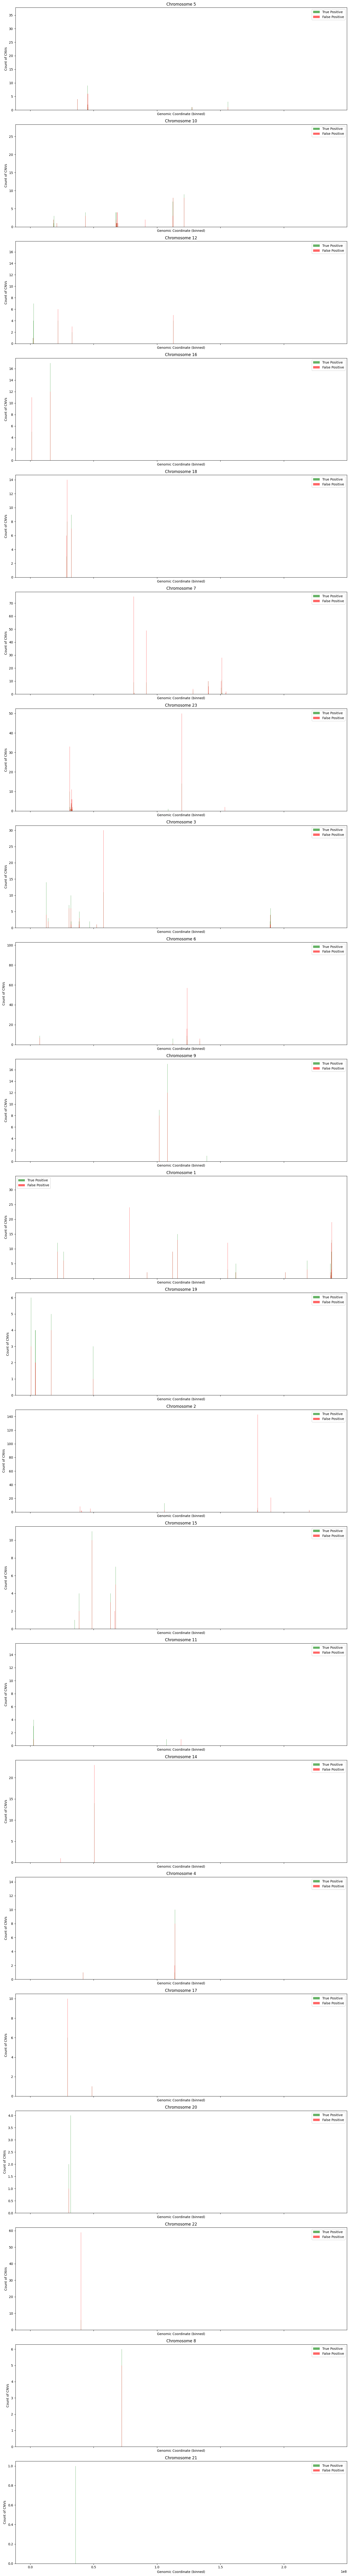

In [123]:
# Define bin size
bin_size = 100000  # 100kb bins

# Create bins for start position
df['start_bin'] = (df['start'] // bin_size) * bin_size

# Group by chromosome, bin, and true_positive to count CNVs
grouped = df.groupby(['chr', 'start_bin', 'true_positive_encoded']).size().reset_index(name='count')

# Pivot the table to have true_positive as columns
pivot_table = grouped.pivot_table(index=['chr', 'start_bin'], columns='true_positive_encoded', values='count', fill_value=0)
pivot_table.columns = ['false_positive_encoded', 'true_positive_encoded']
pivot_table = pivot_table.reset_index()

# Plotting
chromosomes = df['chr'].unique()
fig, axes = plt.subplots(len(chromosomes), 1, figsize=(15, 5 * len(chromosomes)), sharex=True)

for ax, chr in zip(axes, chromosomes):
    chr_data = pivot_table[pivot_table['chr'] == chr]
    ax.bar(chr_data['start_bin'], chr_data['true_positive_encoded'], width=bin_size, color='green', alpha=0.6, label='True Positive')
    ax.bar(chr_data['start_bin'], chr_data['false_positive_encoded'], width=bin_size, color='red', alpha=0.6, label='False Positive')
    ax.set_title(f'Chromosome {chr}')
    ax.set_xlabel('Genomic Coordinate (binned)')
    ax.set_ylabel('Count of CNVs')
    ax.legend()

plt.tight_layout()
plt.show()

In [126]:
contingency_table = df.groupby(['decon', 'gatk', 'grapes', 'true_positive_encoded']).size().unstack(fill_value=0)

print("Contingency Table:\n", contingency_table)

Contingency Table:
 true_positive_encoded     0    1
decon gatk grapes               
0     0    1            351   21
      1    0            165   14
           1             33   15
1     0    0           1178   73
           1             41   88
      1    0             42   80
           1             54  837


In [133]:
!pip install matplotlib-venn


Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_37674/407563728.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tp_count = df.loc[indexes, 'true_positive_encoded'].sum()
/tmp/ipykernel_37674/407563728.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tp_count = df.loc[indexes, 'true_positive_encoded'].sum()
/tmp/ipykernel_37674/407563728.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tp_count = df.loc[indexes, 'true_positive_encoded'].sum()
/tmp/ipykernel_37674/407563728.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tp_count = df.loc[indexes, 'true_positive_encoded'].sum()
/tmp/ipykernel_37674/407563728.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tp_

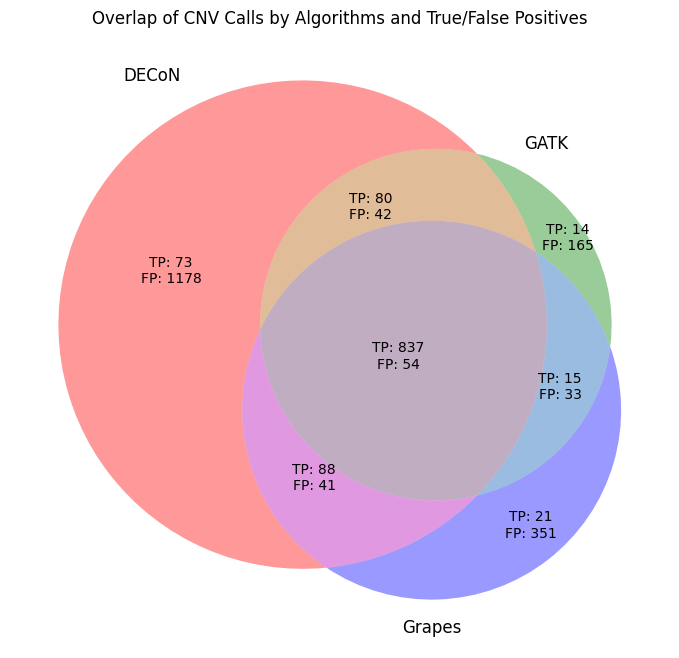

In [139]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
# Create sets for the Venn diagram
set_decon = set(df[df['decon'] == 1].index)
set_gatk = set(df[df['gatk'] == 1].index)
set_grapes = set(df[df['grapes'] == 1].index)

# Create the Venn diagram
plt.figure(figsize=(10, 8))
venn = venn3([set_decon, set_gatk, set_grapes], ('DECoN', 'GATK', 'Grapes'))

# Function to count true positives and false positives in a given set
def count_tp_fp(indexes, df):
    tp_count = df.loc[indexes, 'true_positive_encoded'].sum()
    fp_count = len(indexes) - tp_count
    return tp_count, fp_count

# Define the regions in the Venn diagram
regions = {
    '100': set_decon - set_gatk - set_grapes,
    '010': set_gatk - set_decon - set_grapes,
    '001': set_grapes - set_decon - set_gatk,
    '110': set_decon & set_gatk - set_grapes,
    '101': set_decon & set_grapes - set_gatk,
    '011': set_gatk & set_grapes - set_decon,
    '111': set_decon & set_gatk & set_grapes
}

# Annotate the Venn diagram
for region, indexes in regions.items():
    tp_count, fp_count = count_tp_fp(indexes, df)
    if venn.get_label_by_id(region) is not None:
        venn.get_label_by_id(region).set_text(f'TP: {tp_count}\nFP: {fp_count}')

plt.title('Overlap of CNV Calls by Algorithms and True/False Positives')
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/venn_diagram.png")
plt.show()

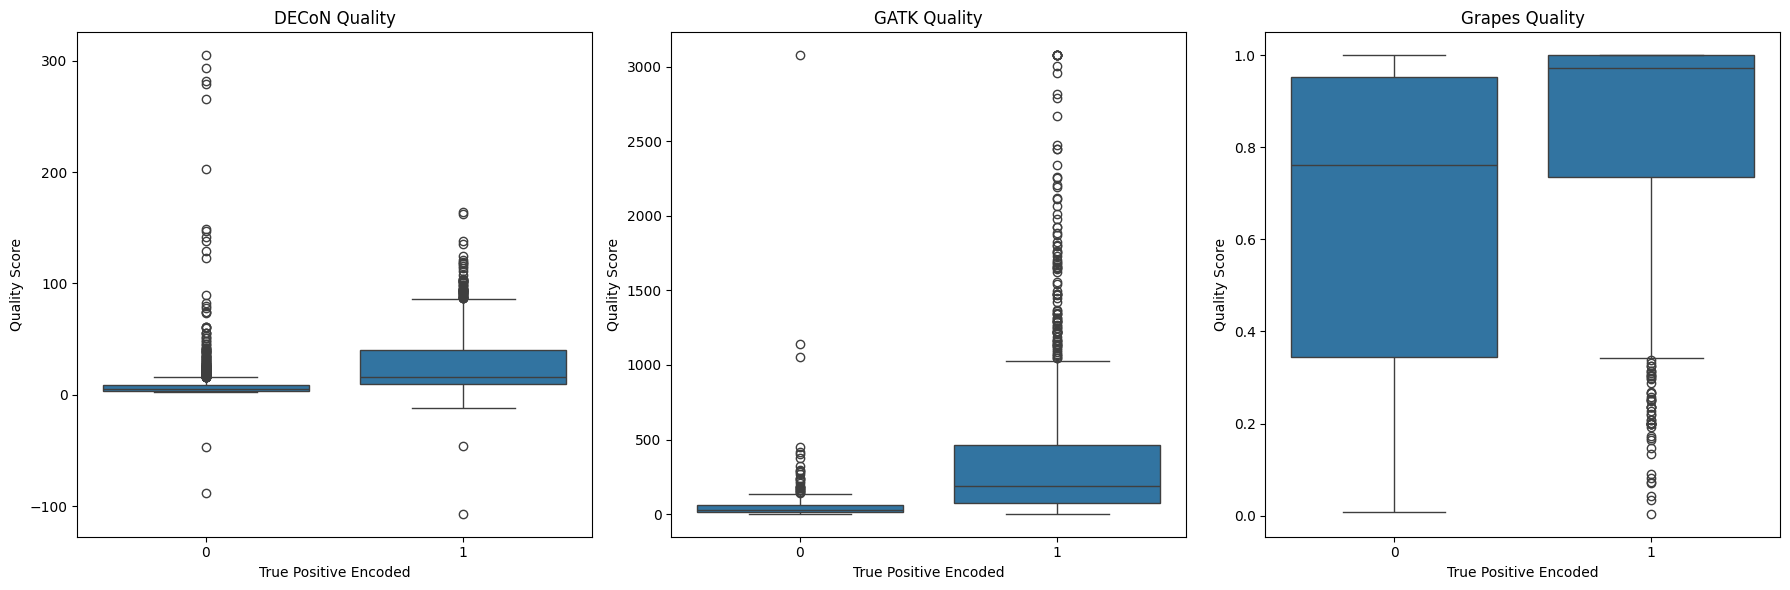

In [143]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))


# DECoN
sns.boxplot(x='true_positive_encoded', y='decon_qual', data=df, ax=axs[0])
axs[0].set_title('DECoN Quality')
axs[0].set_xlabel('True Positive Encoded')
axs[0].set_ylabel('Quality Score')

# GATK
sns.boxplot(x='true_positive_encoded', y='gatk_qual', data=df, ax=axs[1])
axs[1].set_title('GATK Quality')
axs[1].set_xlabel('True Positive Encoded')
axs[1].set_ylabel('Quality Score')

# Grapes
sns.boxplot(x='true_positive_encoded', y='grapes_qual', data=df, ax=axs[2])
axs[2].set_title('Grapes Quality')
axs[2].set_xlabel('True Positive Encoded')
axs[2].set_ylabel('Quality Score')

plt.tight_layout()
plt.show()

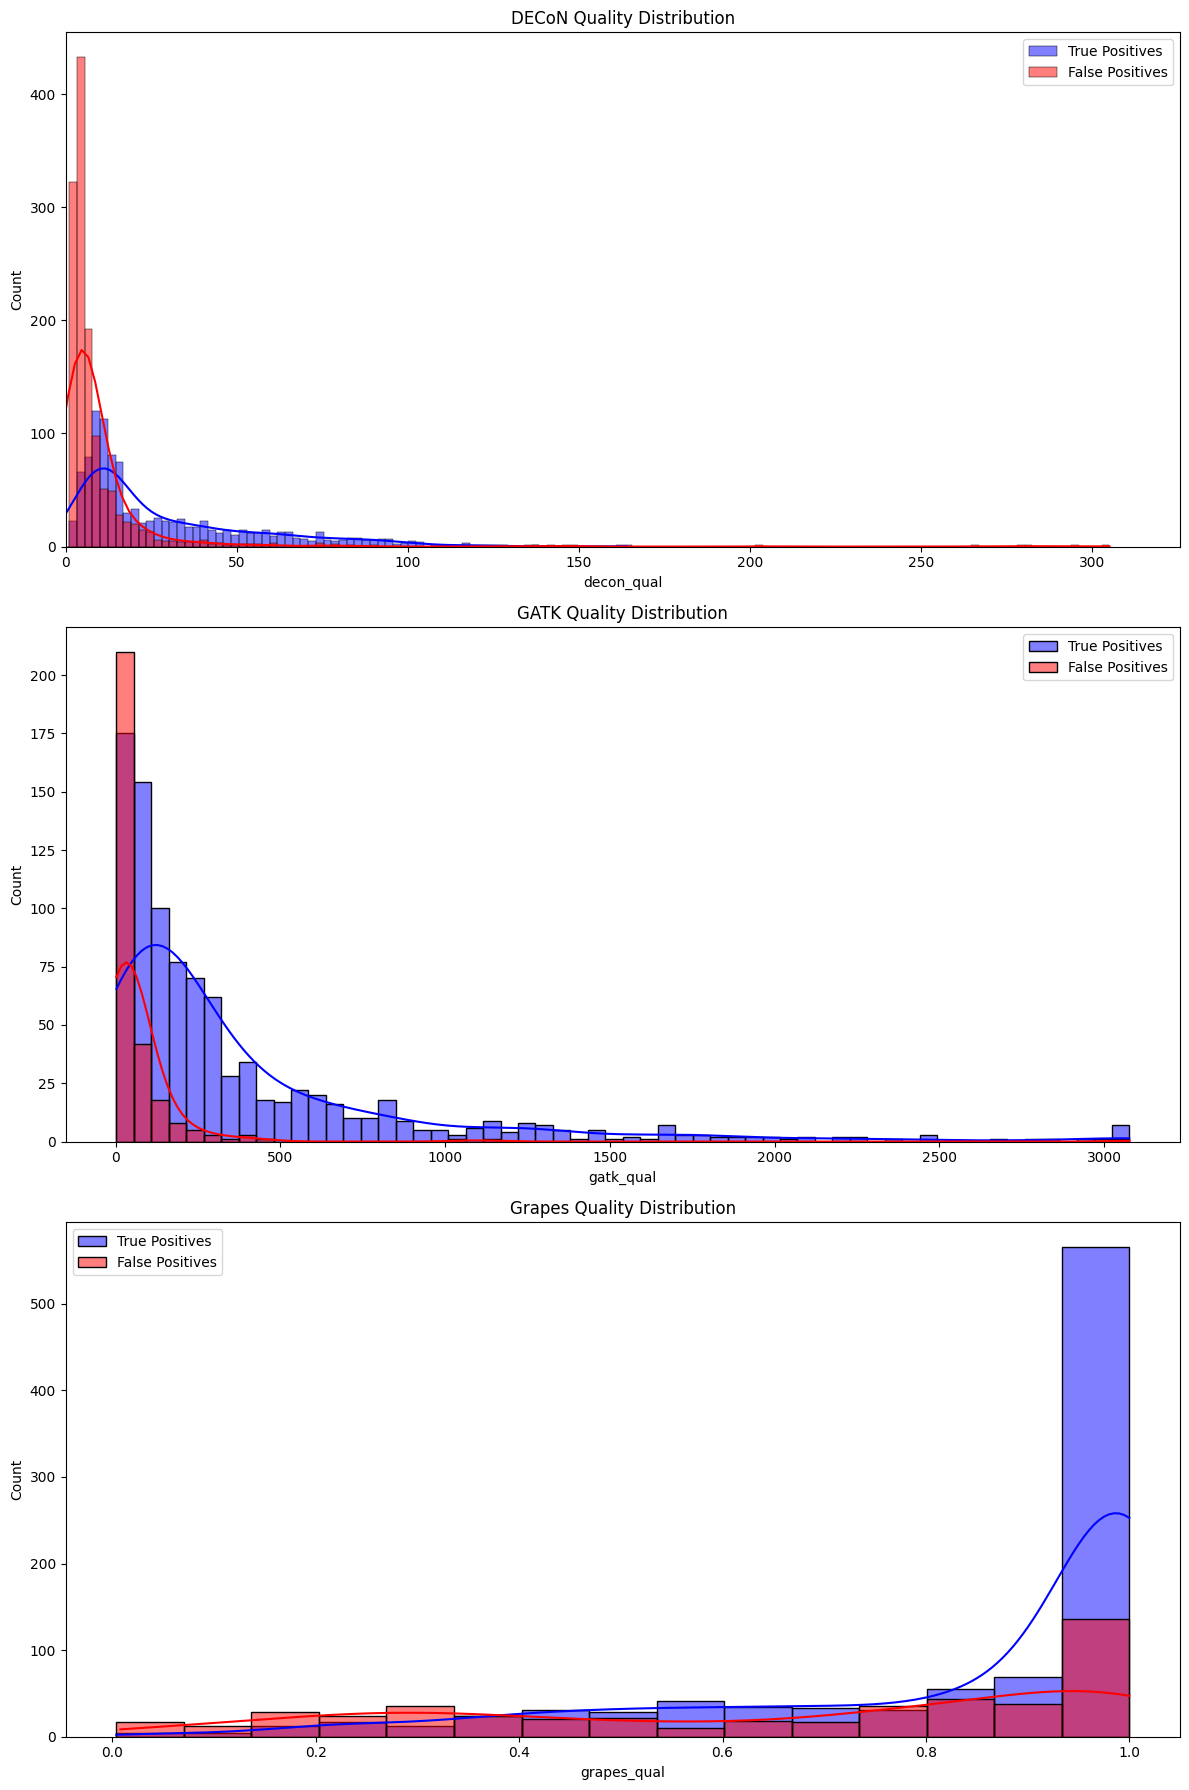

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Remove NaN values for each algorithm's quality scores
decon_qual_clean = pd.concat([df['decon_qual'][df['true_positive_encoded'] == 1].dropna(), df['decon_qual'][df['true_positive_encoded'] == 0].dropna()])
gatk_qual_clean = pd.concat([df['gatk_qual'][df['true_positive_encoded'] == 1].dropna(), df['gatk_qual'][df['true_positive_encoded'] == 0].dropna()])
grapes_qual_clean = pd.concat([df['grapes_qual'][df['true_positive_encoded'] == 1].dropna(), df['grapes_qual'][df['true_positive_encoded'] == 0].dropna()])

# Calculate bin edges using the cleaned data for each algorithm
bins_decon = np.histogram_bin_edges(decon_qual_clean, bins='auto')
bins_gatk = np.histogram_bin_edges(gatk_qual_clean, bins='auto')
bins_grapes = np.histogram_bin_edges(grapes_qual_clean, bins='auto')

fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# DECoN
sns.histplot(df[df['true_positive_encoded'] == 1]['decon_qual'].dropna(), color='blue', label='True Positives', ax=axs[0], bins=bins_decon, kde=True)
sns.histplot(df[df['true_positive_encoded'] == 0]['decon_qual'].dropna(), color='red', label='False Positives', ax=axs[0], bins=bins_decon, kde=True)
axs[0].set_title('DECoN Quality Distribution')
axs[0].legend()
axs[0].set_xlim(left=0)  # Start x-axis at 0

# GATK
sns.histplot(df[df['true_positive_encoded'] == 1]['gatk_qual'].dropna(), color='blue', label='True Positives', ax=axs[1], bins=bins_gatk, kde=True)
sns.histplot(df[df['true_positive_encoded'] == 0]['gatk_qual'].dropna(), color='red', label='False Positives', ax=axs[1], bins=bins_gatk, kde=True)
axs[1].set_title('GATK Quality Distribution')
axs[1].legend()

# Grapes
sns.histplot(df[df['true_positive_encoded'] == 1]['grapes_qual'].dropna(), color='blue', label='True Positives', ax=axs[2], bins=bins_grapes, kde=True)
sns.histplot(df[df['true_positive_encoded'] == 0]['grapes_qual'].dropna(), color='red', label='False Positives', ax=axs[2], bins=bins_grapes, kde=True)
axs[2].set_title('Grapes Quality Distribution')
axs[2].legend()

plt.tight_layout()
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/alg_qualities.png")
plt.show()

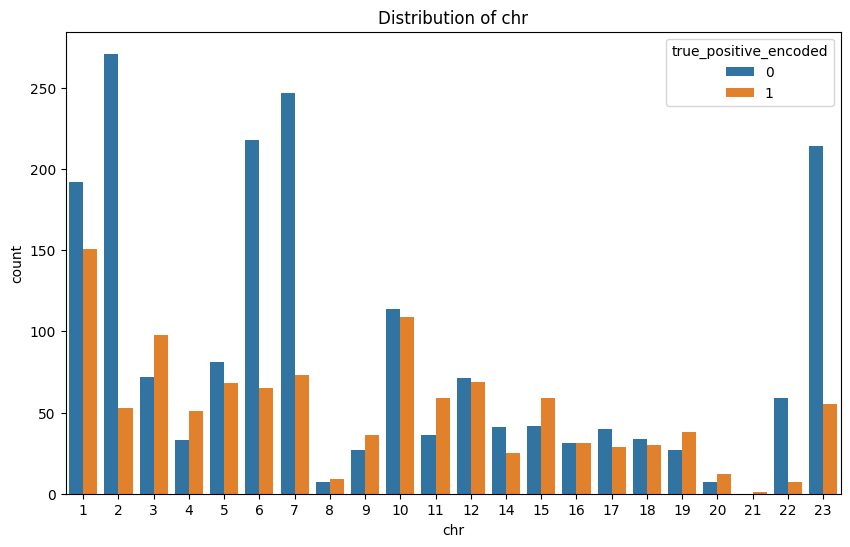

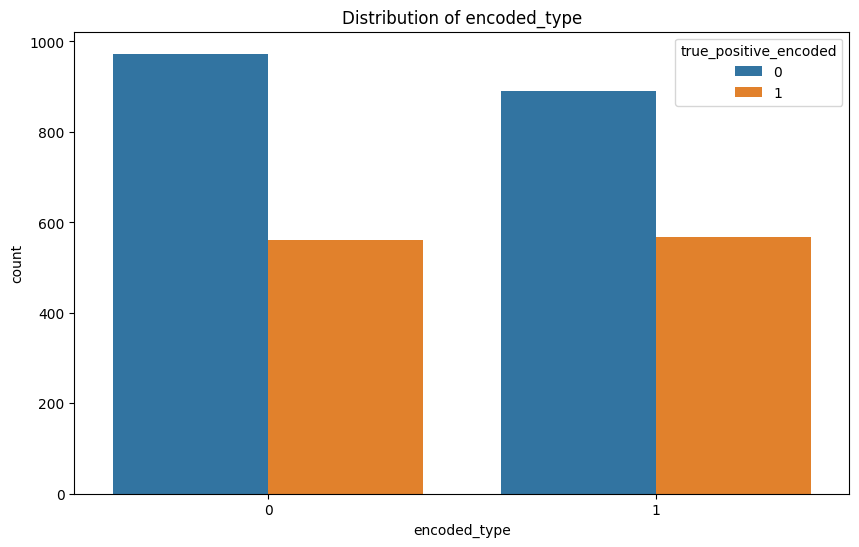

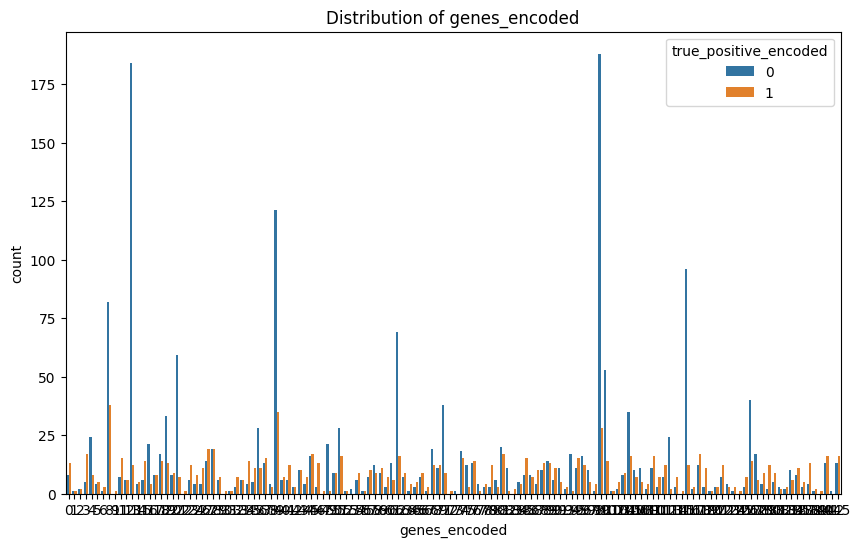

In [163]:
categorical_vars = ['chr', 'encoded_type', 'genes_encoded']
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=var, hue='true_positive_encoded')
    plt.title(f'Distribution of {var}')
    plt.show()

In [157]:
df.columns

Index(['start', 'end', 'chr', 'numb_exons', 'decon', 'gatk', 'cnvkit',
       'grapes', 'gc_content', 'mappability', 'cnv_length', 'decon_qual',
       'gatk_qual', 'cnvkit_qual', 'grapes_qual', 'cnv_origin',
       'sample_correlation', 'is_autosomal', 'genes_encoded', 'encoded_type',
       'true_positive_encoded', 'start_bin'],
      dtype='object')

In [194]:
# Count the number of false positives per gene
false_positive_counts = df2[df2['true_positive'] == False]['gene'].value_counts()

# Select top 10 genes with the most false positives
top_genes = false_positive_counts.head(10).index

# Filter DataFrame to include only the top genes
filtered_df = df2[df2['gene'].isin(top_genes)]

# Create a binary column for counting purposes
filtered_df['count'] = 1

# Group by gene and true positive status, and sum counts
summary_df = filtered_df.groupby(['gene', 'true_positive'])['count'].sum().unstack(fill_value=0)

# Reset index to have a tidy DataFrame
summary_df = summary_df.reset_index()
summary_df = summary_df.melt(id_vars='gene', var_name='true_positive', value_name='count')

# Convert the 'true_positive_encoded' to string for better plotting
summary_df['true_positive'] = summary_df['true_positive'].astype(str)

# Display the summary DataFrame for verification
print(summary_df)

        gene true_positive  count
0      AKAP9         False     69
1    CACNA1I         False     59
2   CACNA2D1         False     96
3        DMD         False    121
4      LAMP2         False     53
5     NUP155         False     40
6       RYR2         False     82
7       SOS1         False     38
8       TRDN         False    188
9        TTN         False    184
10     AKAP9          True     16
11   CACNA1I          True      7
12  CACNA2D1          True     12
13       DMD          True     35
14     LAMP2          True     14
15    NUP155          True     14
16      RYR2          True     38
17      SOS1          True      9
18      TRDN          True     28
19       TTN          True     12


/tmp/ipykernel_37674/35072810.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['count'] = 1


       gene true_positive  count
0     AKAP9         False     69
1   CACNA1I         False     59
2  CACNA2D1         False     96
3       DMD         False    121
4     LAMP2         False     53


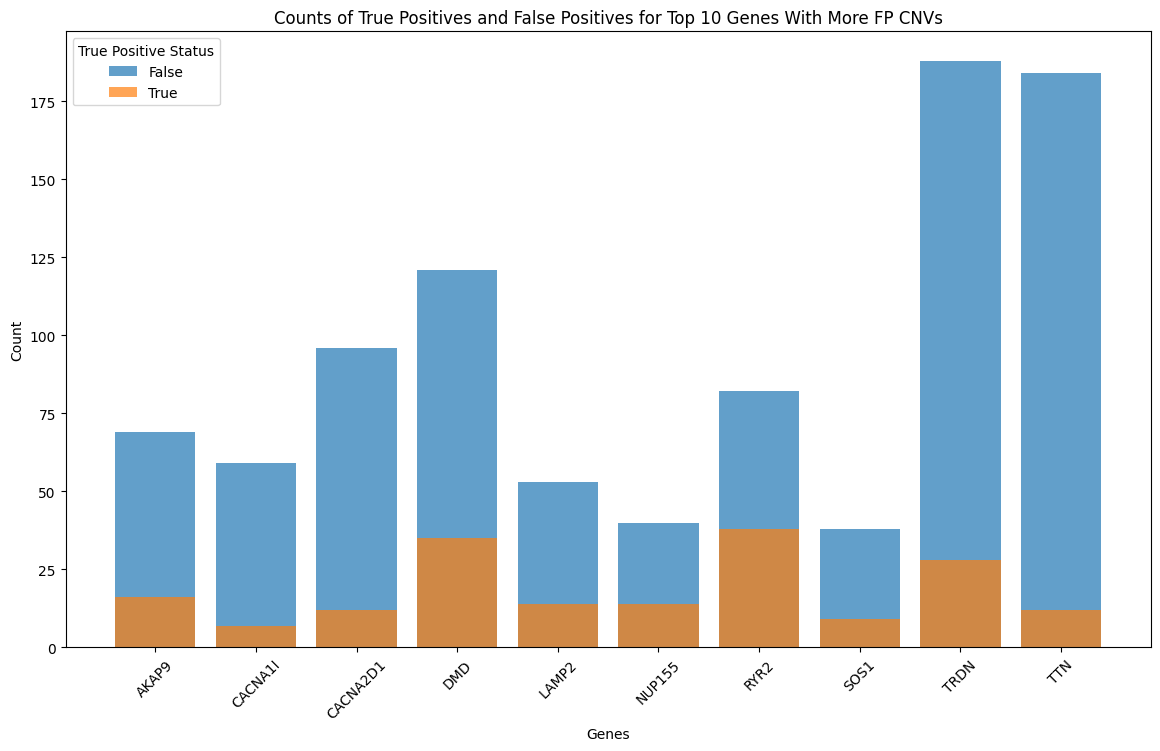

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

print(summary_df.head())


# Set up the plot
plt.figure(figsize=(14, 8))

# Create a bar plot
for label, df_group in summary_df.groupby('true_positive'):
    plt.bar(df_group['gene'], df_group['count'], label=label, alpha=0.7)

# Customize the plot
plt.xlabel('Genes')
plt.ylabel('Count')
plt.title('Counts of True Positives and False Positives for Top 10 Genes With More FP CNVs')
plt.xticks(rotation=45)  # Rotate gene names for better visibility
plt.legend(title='True Positive Status')
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/top_false_positive_calls.png")

# Show the plot
plt.show()

/tmp/ipykernel_37674/1783348135.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['count'] = 1


       gene true_positive  count
0      ANK2         False     16
1   CACNA1C         False      5
2     CASQ2         False     13
3    CTNNA3         False     19
4       DMD         False    121
5      FKTN         False     12
6      HCN1         False     20
7     MYH11         False     14
8      RYR2         False     82
9      TRDN         False    188
10     ANK2          True     17
11  CACNA1C          True     17
12    CASQ2          True     16
13   CTNNA3          True     19
14      DMD          True     35
15     FKTN          True     17
16     HCN1          True     17
17    MYH11          True     19
18     RYR2          True     38
19     TRDN          True     28
      gene true_positive  count
0     ANK2         False     16
1  CACNA1C         False      5
2    CASQ2         False     13
3   CTNNA3         False     19
4      DMD         False    121


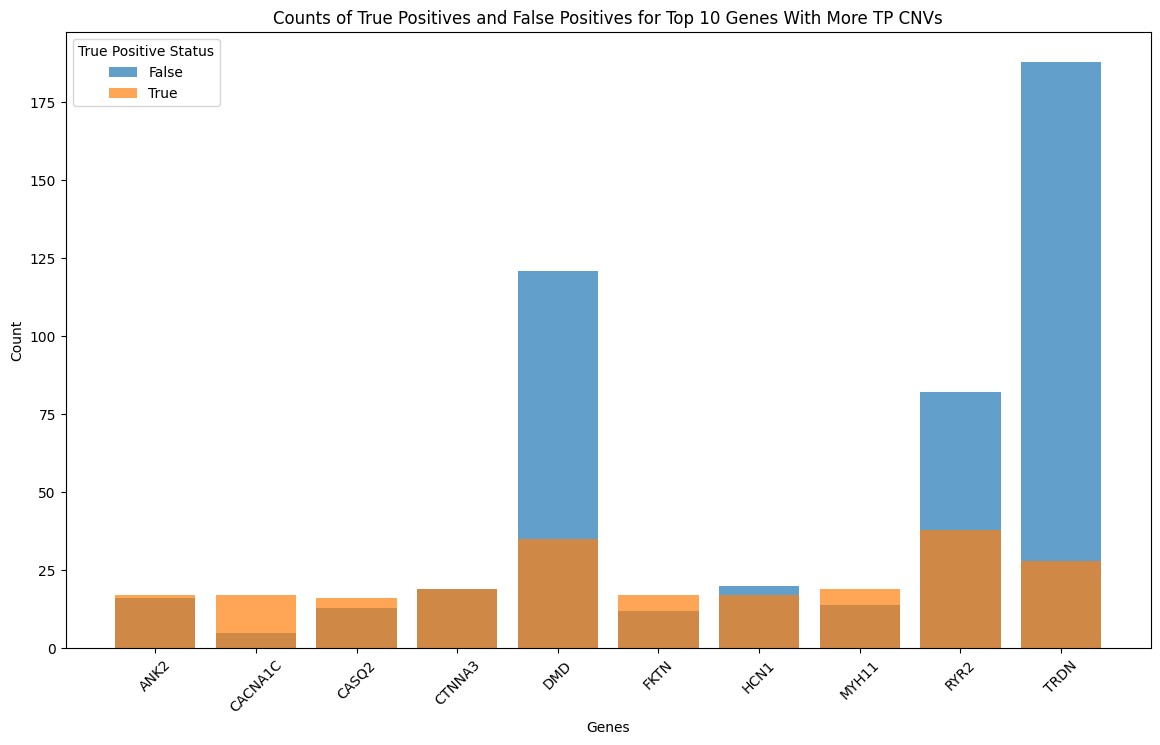

In [197]:
# Count the number of false positives per gene
false_positive_counts = df2[df2['true_positive'] == True]['gene'].value_counts()

# Select top 10 genes with the most false positives
top_genes = false_positive_counts.head(10).index

# Filter DataFrame to include only the top genes
filtered_df = df2[df2['gene'].isin(top_genes)]

# Create a binary column for counting purposes
filtered_df['count'] = 1

# Group by gene and true positive status, and sum counts
summary_df = filtered_df.groupby(['gene', 'true_positive'])['count'].sum().unstack(fill_value=0)

# Reset index to have a tidy DataFrame
summary_df = summary_df.reset_index()
summary_df = summary_df.melt(id_vars='gene', var_name='true_positive', value_name='count')

# Convert the 'true_positive_encoded' to string for better plotting
summary_df['true_positive'] = summary_df['true_positive'].astype(str)

# Display the summary DataFrame for verification
print(summary_df)

print(summary_df.head())


# Set up the plot
plt.figure(figsize=(14, 8))

# Create a bar plot
for label, df_group in summary_df.groupby('true_positive'):
    plt.bar(df_group['gene'], df_group['count'], label=label, alpha=0.7)

# Customize the plot
plt.xlabel('Genes')
plt.ylabel('Count')
plt.title('Counts of True Positives and False Positives for Top 10 Genes With More TP CNVs')
plt.xticks(rotation=45)  # Rotate gene names for better visibility
plt.legend(title='True Positive Status')
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/top_true_positive_calls.png")
# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

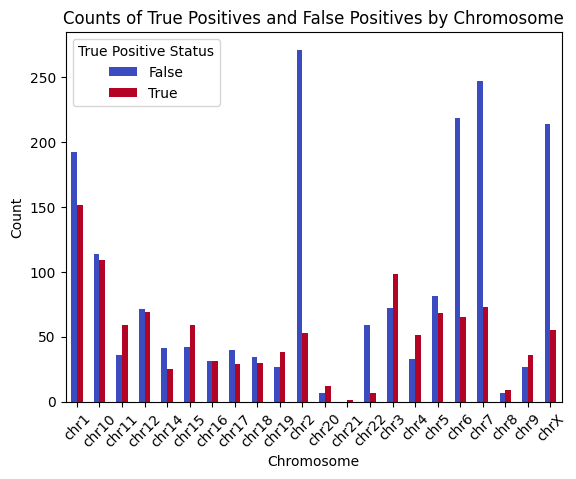

In [200]:
# Count occurrences per chromosome and status
counts = df2.groupby(['chr', 'true_positive']).size().unstack(fill_value=0)

# Set up the plot
plt.figure(figsize=(12, 8))

# Bar plot
counts.plot(kind='bar', stacked=False, colormap='coolwarm')

# Customize the plot
plt.xlabel('Chromosome')
plt.ylabel('Count')
plt.title('Counts of True Positives and False Positives by Chromosome')
plt.xticks(rotation=45)  # Rotate chromosome labels for better visibility
plt.legend(title='True Positive Status')


plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/chr_variable.png")
# Show the plot
plt.show()

In [183]:
df2.columns

Index(['start', 'end', 'chr', 'type', 'sample', 'numb_exons', 'decon', 'gatk',
       'cnvkit', 'grapes', 'gc_content', 'mappability', 'cnv_length', 'gene',
       'qual', 'true_positive', 'decon_qual', 'gatk_qual', 'cnvkit_qual',
       'grapes_qual', 'cnv_origin', 'sample_correlation', 'is_outlier'],
      dtype='object')

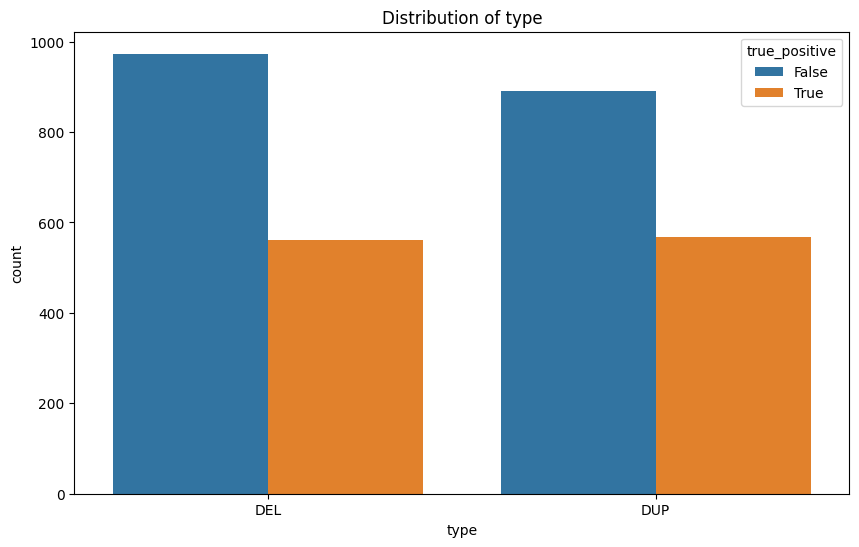

In [203]:
categorical_vars = ['type']
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df2, x=var, hue='true_positive')
    plt.title(f'Distribution of {var}')
    plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/cnv_type_variable.png")
    plt.show()

Pearson correlation coefficient: 0.7380714821065214


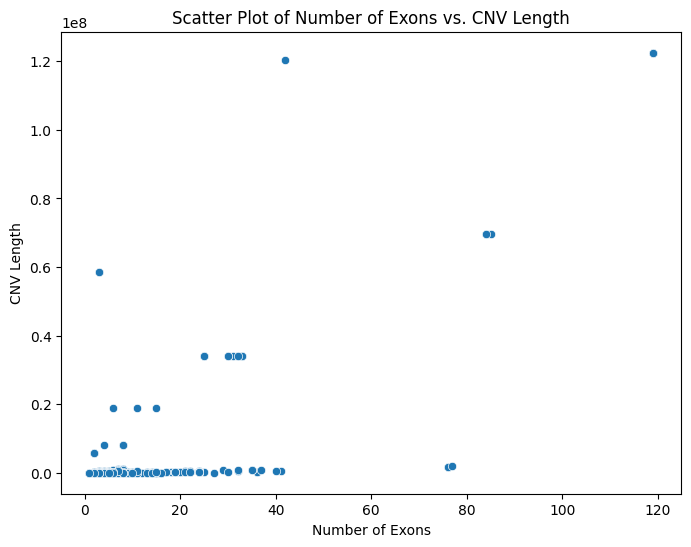

In [210]:
# Assuming df is your DataFrame
correlation = df2['numb_exons'].corr(df2['cnv_length'])
print(f'Pearson correlation coefficient: {correlation}')

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='numb_exons', y='cnv_length', data=df2)
plt.xlabel('Number of Exons')
plt.ylabel('CNV Length')
plt.title('Scatter Plot of Number of Exons vs. CNV Length')
plt.show()

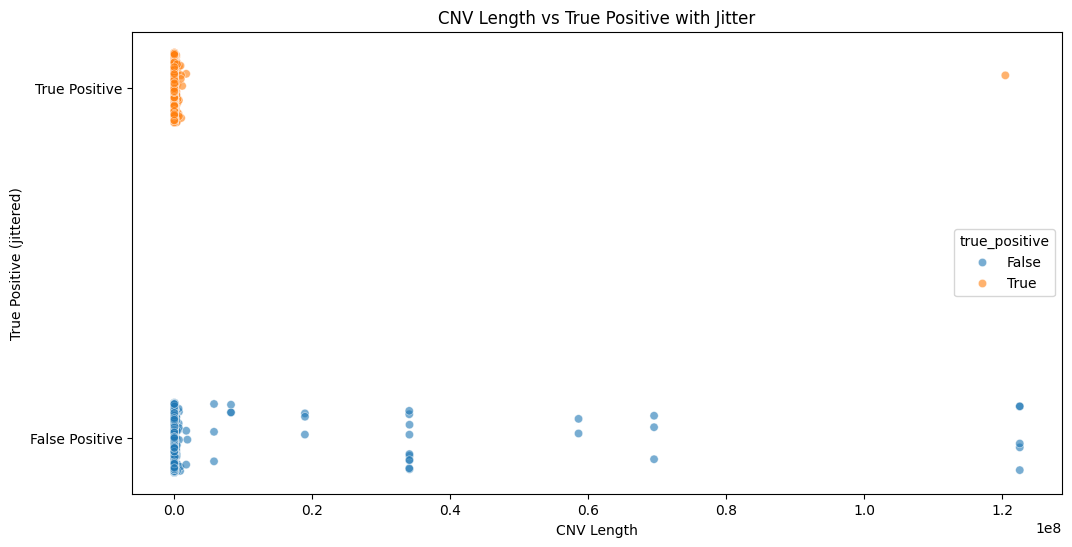

In [221]:
# Create a copy of the dataframe to add jitter
df_jitter = df2.copy()
df_jitter['true_positive_jitter'] = df_jitter['true_positive'] + np.random.uniform(-0.1, 0.1, size=len(df_jitter))

# Plot with jitter
plt.figure(figsize=(12, 6))
sns.scatterplot(x='cnv_length', y='true_positive_jitter', hue='true_positive', data=df_jitter, alpha=0.6)
plt.xlabel('CNV Length')
plt.ylabel('True Positive (jittered)')
plt.title('CNV Length vs True Positive with Jitter')
plt.yticks([0, 1], ['False Positive', 'True Positive'])
plt.show()

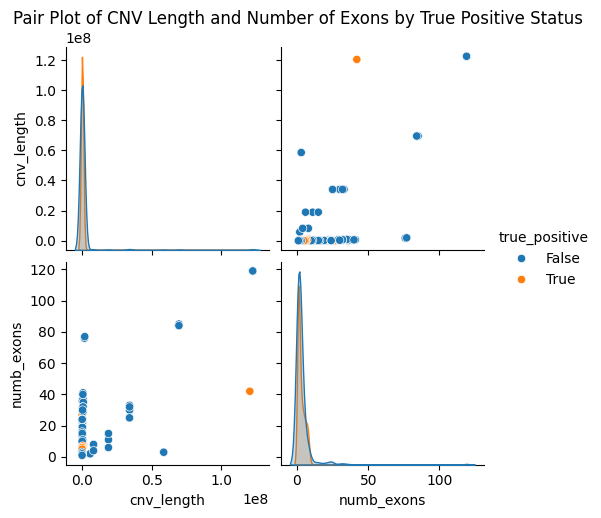

In [222]:
sns.pairplot(df2, hue='true_positive', vars=['cnv_length', 'numb_exons'])
plt.suptitle('Pair Plot of CNV Length and Number of Exons by True Positive Status', y=1.02)
plt.show()

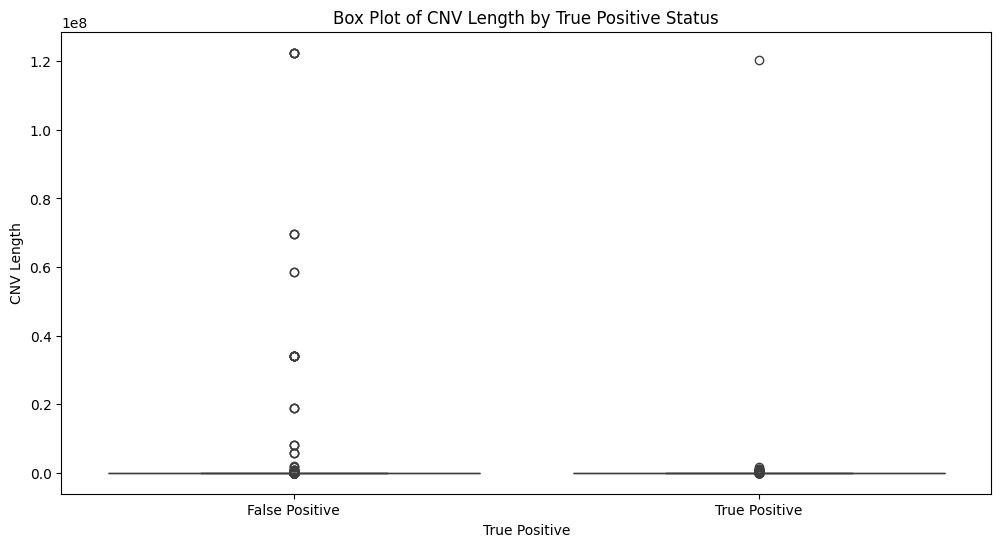

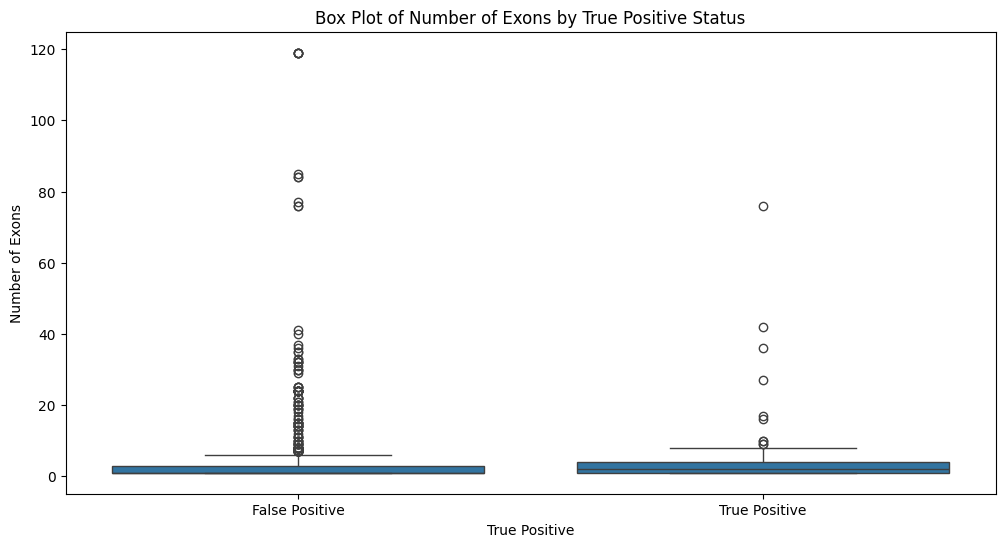

In [232]:
# Box plot for CNV Length
plt.figure(figsize=(12, 6))
sns.boxplot(x='true_positive', y='cnv_length', data=df2)
plt.xlabel('True Positive')
plt.ylabel('CNV Length')
plt.title('Box Plot of CNV Length by True Positive Status')
plt.xticks([0, 1], ['False Positive', 'True Positive'])
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/boxplot_cnv_length.png")
plt.show()

# Box plot for Number of Exons
plt.figure(figsize=(12, 6))
sns.boxplot(x='true_positive', y='numb_exons', data=df2)
plt.xlabel('True Positive')
plt.ylabel('Number of Exons')
plt.title('Box Plot of Number of Exons by True Positive Status')
plt.xticks([0, 1], ['False Positive', 'True Positive'])
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/boxplot_exons.png")
plt.show()

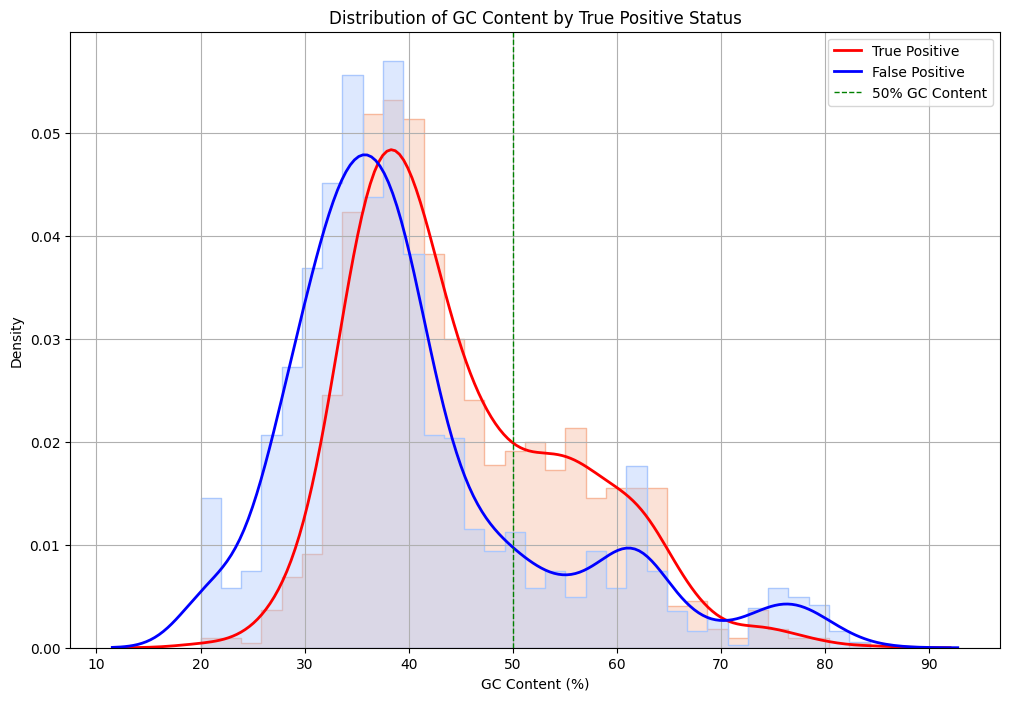

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'gc_content' and 'true_positive' columns
# plt.figure(figsize=(12, 8))

# # Plotting the histogram and density plot
# sns.histplot(data=df2, x='gc_content', hue='true_positive', element='step', stat='density', common_norm=False, palette='coolwarm', alpha=0.4)
# sns.kdeplot(data=df2[df2['true_positive'] == 1]['gc_content'], color='blue', label='True Positive', linewidth=2)
# sns.kdeplot(data=df2[df2['true_positive'] == 0]['gc_content'], color='red', label='False Positive', linewidth=2)

# # Adding a vertical line at 50% GC content
# plt.axvline(50, color='grey', linestyle='--', linewidth=1, label='50% GC Content')

# # Customize the plot
# plt.xlabel('GC Content (%)')
# plt.ylabel('Density')
# plt.title('Distribution of GC Content by True Positive Status')
# plt.legend()
# plt.grid(True)
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'gc_content' and 'true_positive' columns
plt.figure(figsize=(12, 8))

# Plotting the histogram and density plot
sns.histplot(data=df2, x='gc_content', hue='true_positive', element='step', stat='density', common_norm=False, palette='coolwarm', alpha=0.4)
sns.kdeplot(data=df2[df2['true_positive'] == 1]['gc_content'], color='red', label='True Positive', linewidth=2)
sns.kdeplot(data=df2[df2['true_positive'] == 0]['gc_content'], color='blue', label='False Positive', linewidth=2)

# Adding a vertical line at 50% GC content
plt.axvline(50, color='green', linestyle='--', linewidth=1, label='50% GC Content')

# Customize the plot
plt.xlabel('GC Content (%)')
plt.ylabel('Density')
plt.title('Distribution of GC Content by True Positive Status')
plt.legend()
plt.grid(True)
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/gc_content.png")

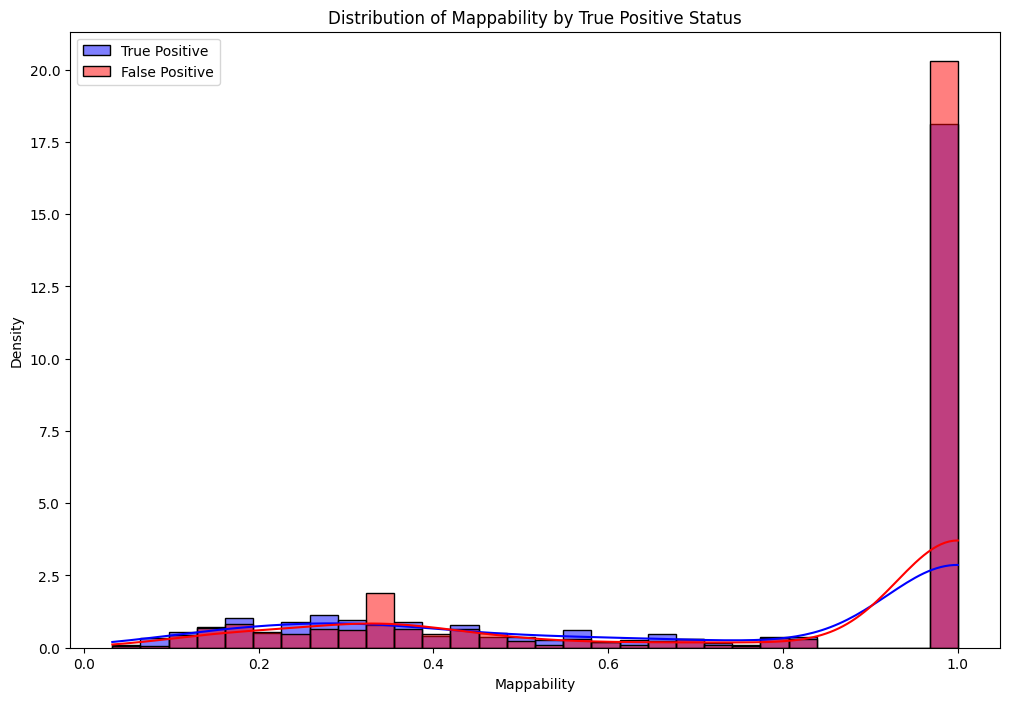

In [243]:

# Separate data for true positives and false positives
true_positives = df2[df2['true_positive'] == 1]
false_positives = df2[df2['true_positive'] == 0]

# Plotting
plt.figure(figsize=(12, 8))

# Density plot for true positives
sns.histplot(true_positives['mappability'], kde=True, color='blue', label='True Positive', stat='density', bins=30, alpha=0.5)

# Density plot for false positives
sns.histplot(false_positives['mappability'], kde=True, color='red', label='False Positive', stat='density', bins=30, alpha=0.5)

plt.xlabel('Mappability')
plt.ylabel('Density')
plt.title('Distribution of Mappability by True Positive Status')
plt.legend()
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/mappability.png")

In [244]:
df2["sample_correlation"].describe()

count    2992.000000
mean        0.854085
std         0.039592
min         0.691958
25%         0.835339
50%         0.858944
75%         0.888852
max         0.901169
Name: sample_correlation, dtype: float64

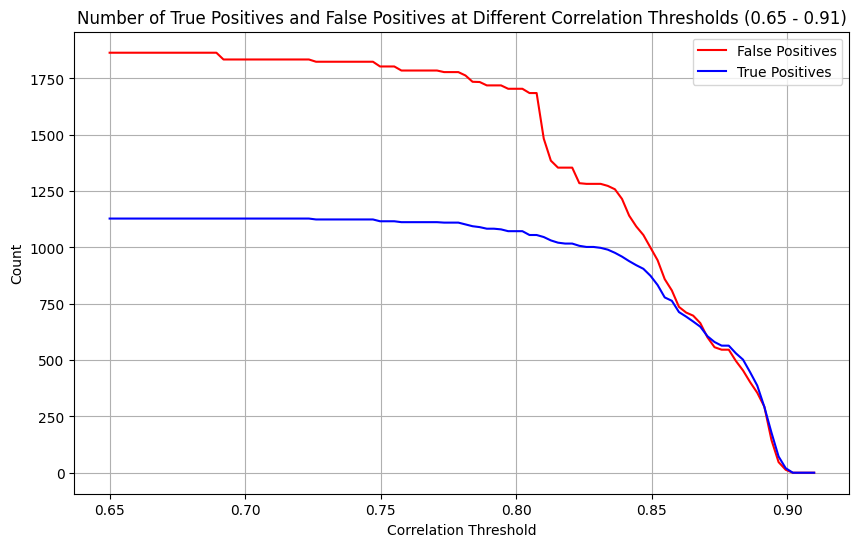

In [250]:
# Define thresholds
thresholds = np.linspace(0.65, 0.91, 100)
false_positives = []
true_positives = []

for threshold in thresholds:
    df2['predicted'] = df2['sample_correlation'] >= threshold
    false_positives.append(df2[(df2['predicted'] == 1) & (df2['true_positive'] == 0)].shape[0])
    true_positives.append(df2[(df2['predicted'] == 1) & (df2['true_positive'] == 1)].shape[0])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, false_positives, label='False Positives', color='red')
plt.plot(thresholds, true_positives, label='True Positives', color='blue')
plt.xlabel('Correlation Threshold')
plt.ylabel('Count')
plt.title('Number of True Positives and False Positives at Different Correlation Thresholds (0.65 - 0.91)')
plt.legend(loc='best')
plt.grid(True)
plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/sample_corr.png")
plt.show()

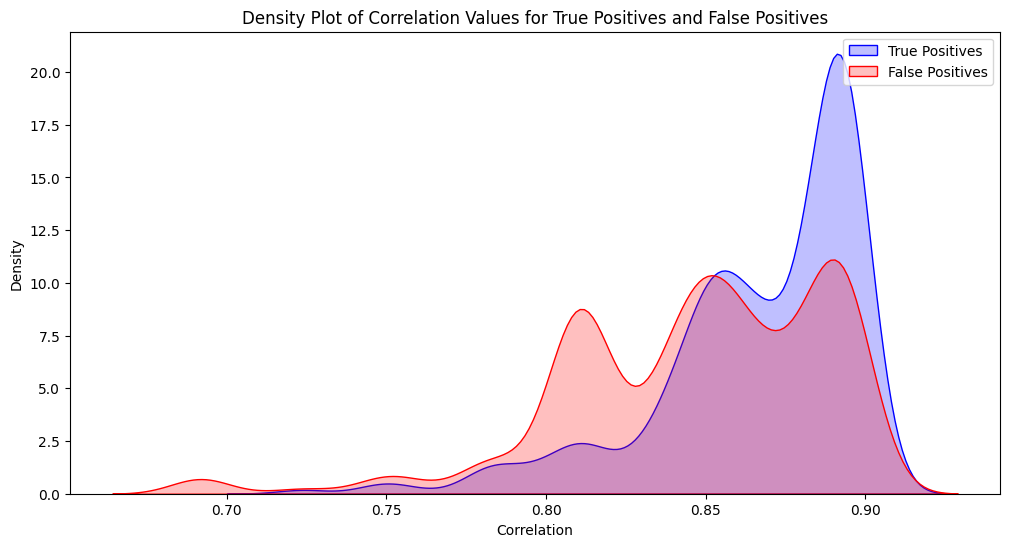

In [259]:
# Create a figure with 2 subplots
# plt.figure(figsize=(12, 6))
# Density Plot for correlation values
plt.figure(figsize=(12, 6))
sns.kdeplot(df2[df2['true_positive'] == 1]['sample_correlation'], color='blue', label='True Positives', fill=True)
sns.kdeplot(df2[df2['true_positive'] == 0]['sample_correlation'], color='red', label='False Positives', fill=True)
plt.title('Density Plot of Correlation Values for True Positives and False Positives')
plt.xlabel('Correlation')
plt.ylabel('Density')
plt.legend(loc='best')

plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/correlation.png")
# # Line Plot for counts of true positives and false positives at different correlation thresholds
# thresholds = np.linspace(0.69, 0.91, 100)
# false_positives = []
# true_positives = []

# for threshold in thresholds:
#     df2['predicted'] = df2['sample_correlation'] >= threshold
#     false_positives.append(df2[(df2['predicted'] == 1) & (df2['true_positive'] == 0)].shape[0])
#     true_positives.append(df2[(df2['predicted'] == 1) & (df2['true_positive'] == 1)].shape[0])


# axes[1].plot(thresholds, false_positives, label='False Positives', color='red')
# axes[1].plot(thresholds, true_positives, label='True Positives', color='blue')
# axes[1].set_xlabel('Correlation Threshold')
# axes[1].set_ylabel('Count')
# axes[1].set_title('Number of True Positives and False Positives at Different Correlation Thresholds (0.69 - 0.91)')
# axes[1].legend(loc='best')
# axes[1].grid(True)
# plt.tight_layout()
# plt.savefig("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/template/imatges/correlation_complete.png")
# plt.show()

In [226]:
import statsmodels.api as sm


X = df2[['cnv_length', 'numb_exons']]
X = sm.add_constant(X)  # Adds a constant term to the model
y = df2['true_positive']

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.661013
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          true_positive   No. Observations:                 2992
Model:                          Logit   Df Residuals:                     2989
Method:                           MLE   Df Model:                            2
Date:                Sun, 28 Jul 2024   Pseudo R-squ.:                0.002363
Time:                        17:49:02   Log-Likelihood:                -1977.8
converged:                       True   LL-Null:                       -1982.4
Covariance Type:            nonrobust   LLR p-value:                  0.009235
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5019      0.045    -11.257      0.000      -0.589      -0.415
cnv_length -3.227e-08   1.57e

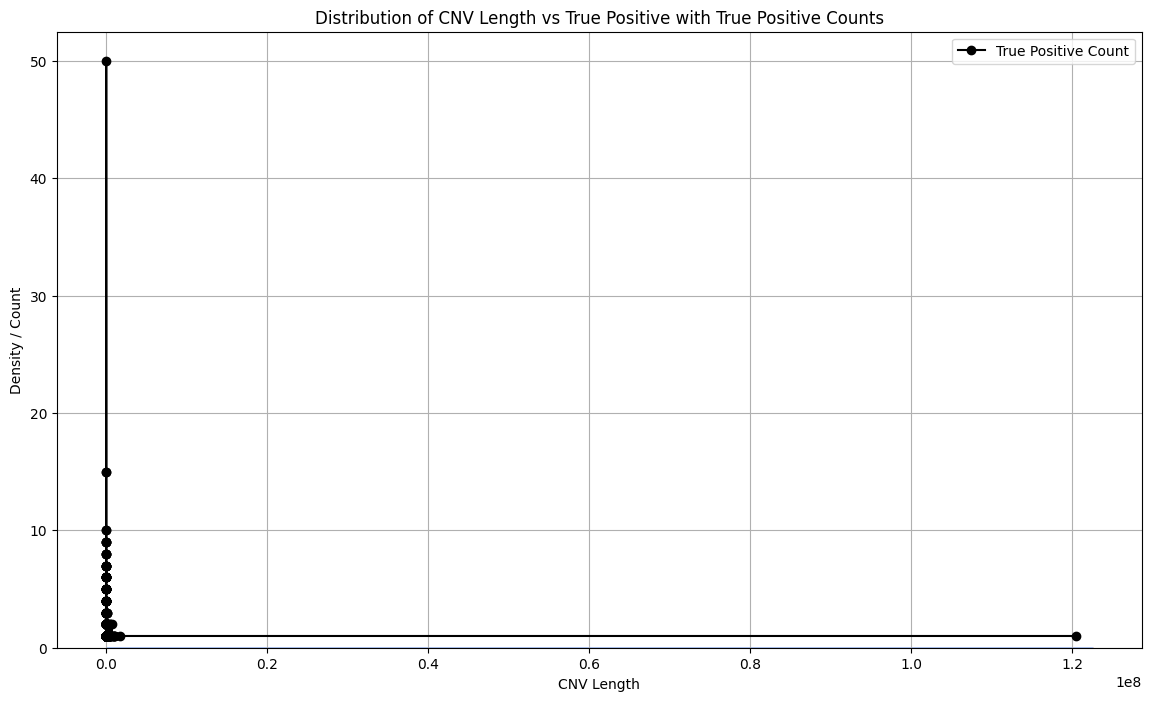

In [231]:
# Create a column for true_positive counts for each cnv_length
true_positive_counts = df2[df2['true_positive'] == 1].groupby('cnv_length').size().reset_index(name='true_count')

# Plotting
plt.figure(figsize=(14, 8))

# Histogram for cnv_length distribution colored by true_positive
sns.histplot(data=df2, x='cnv_length', hue='true_positive', element='step', stat='density', common_norm=False, palette='coolwarm')

# Line plot for true positive counts
plt.plot(true_positive_counts['cnv_length'], true_positive_counts['true_count'], color='black', marker='o', linestyle='-', label='True Positive Count')

# Customize the plot
plt.xlabel('CNV Length')
plt.ylabel('Density / Count')
plt.title('Distribution of CNV Length vs True Positive with True Positive Counts')
plt.legend()
plt.grid(True)
plt.show()

In [219]:
from sklearn.inspection import plot_partial_dependence
X_train, X_test, y_train, y_test = train_test_split(df[['numb_exons', 'cnv_length']], df['true_positive'], test_size=0.3, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Plot partial dependence
fig, ax = plt.subplots(figsize=(12, 6))
plot_partial_dependence(model, X_train, ['numb_exons', 'cnv_length'], ax=ax)
plt.suptitle('Partial Dependence Plots for Number of Exons and CNV Length')
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/home/ocanal/.local/lib/python3.10/site-packages/sklearn/inspection/__init__.py)

In [213]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Create a DataFrame with the variables to check
X = df[['numb_exons', 'cnv_length']]
X = add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     Variable       VIF
0       const  1.350539
1  numb_exons  2.196593
2  cnv_length  2.196593


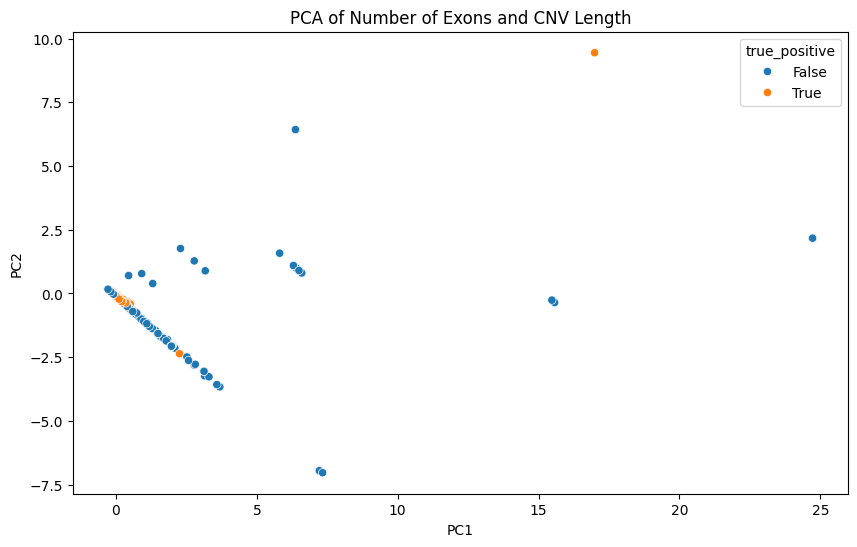

Explained variance ratio: [0.86903574 0.13096426]


In [216]:
from sklearn.decomposition import PCA
X = df2[['numb_exons', 'cnv_length']]
y = df2['true_positive']
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['true_positive'] = y.values

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='true_positive', data=pca_df)
plt.title('PCA of Number of Exons and CNV Length')
plt.show()

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

In [172]:
df2 = pd.read_csv("/home/ocanal/Desktop/CNV_detection_on_targeted_sequencing/cnv_excel.csv")

In [178]:
df2["gene"]

AttributeError: 'Series' object has no attribute 'values_count'

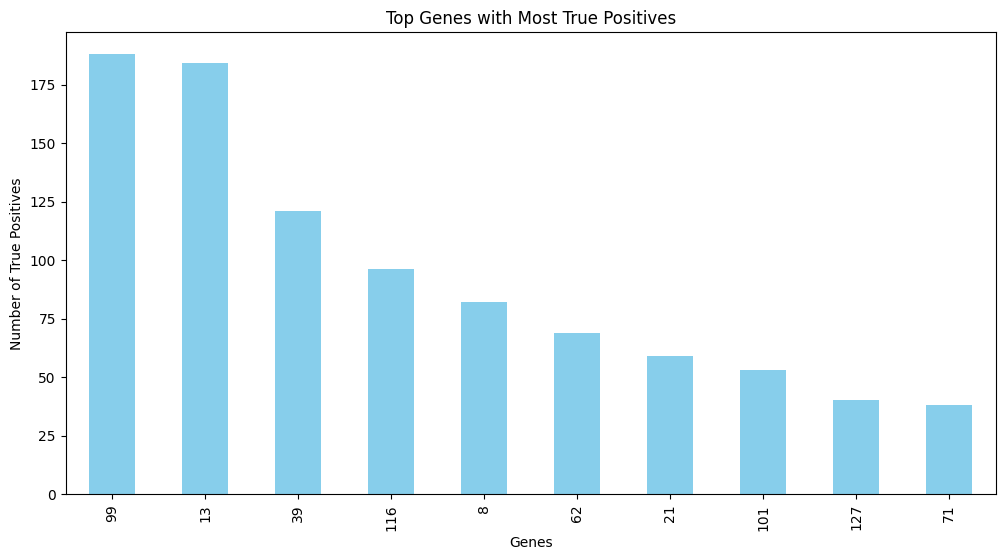

In [174]:
# Count the number of true positives per gene
false_positive_counts = df2[df2['true_positive'] == False]['gene'].value_counts()

true_positive_counts

# Select top N genes with the most true positives
top_genes = true_positive_counts.head(10).index
top_true_positive_counts = true_positive_counts.head(10)

# Plot bar chart for top genes
plt.figure(figsize=(12, 6))
top_true_positive_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Genes')
plt.ylabel('Number of True Positives')
plt.title('Top Genes with Most True Positives')
plt.xticks(rotation=90)
plt.show()

In [132]:

# Reset index without creating new conflicting columns
contingency_table = contingency_table.reset_index()

# Pivot the table for heatmap
heatmap_data = contingency_table.pivot_table(index=['decon', 'gatk', 'grapes'], columns='true_positive_encoded', values=0, fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Contingency Table Heatmap')
plt.xlabel('True Positive Encoded')
plt.ylabel('Predictor Combinations')
plt.show()

ValueError: cannot insert level_0, already exists

In [1]:
a = True